# LLM intervention + Activation patching tutorial
### Wednesday October 15th

**Welcome to the third lab for [AI Safety and Alignment](https://robots.ox.ac.uk/~fazl/aisaa/), MT 2025!**

This lab is split into two parts:

* 1️⃣ We'll first introduce the `TransformerLens` (TL) library, recall the basics of transformer-based large language models, and see how TL provides useful tools for inspecting intermediate activations, and intervening during the forward pass.
    * During this introduction, we'll learn how to add activation hooks to ablate various components--a very rudimentary tool for mechanistic interpretability!
* 2️⃣ Following this, we'll jump into an excellent (shortened) tutorial directly from [ARENA](https://arena-chapter1-transformer-interp.streamlit.app/[1.4.1]_Indirect_Object_Identification), which walks through how to use two additional tools for mechanistic interpretability of large language models:
    * [**direct logit attribution**](https://dynalist.io/d/n2ZWtnoYHrU1s4vnFSAQ519J#z=disz2gTx-jooAcR0a5r8e7LZ)
    * and [**activation patching**](https://arxiv.org/abs/2202.05262)
    
The lab will introduce a range of tools for mechanistic interpretability by way of exploring the so-called ['indirect object identification'](https://arxiv.org/abs/2211.00593) (an optional paper on the day 3 reading list) task to ground our exploration. We'll see more details about this task later (note: this notebook aims to be totally self-contained, and no prior familiarity with the task should be necessary)

<div style="
  border-left: 6px solid #e58e26;
  background: linear-gradient(90deg, #fff8f0 0%, #fff4e6 100%);
  padding: 1rem 1.25rem;
  margin: 1.5rem 0;
  border-radius: 10px;
  box-shadow: 0 2px 6px rgba(0,0,0,0.05);
">
  <h2 style="
    color: #e58e26;
    margin-top: 0;
    margin-bottom: 0.5rem;
    letter-spacing: 0.5px;
  ">Scope & focus</h2>
  <p style="margin: 0; color: #2f3e46; line-height: 1.5;">
This lab is focused on one particular aspect of mechanistic interpretability: finding evidence for the importance of particular layers' activations for implementing algorithmic behaviour.

There are many other areas of mechanistic interpretability we won't have time to cover. Other popular techniques include (some of which were discussed in the lecture):
* **Learning interpretable components or features** inside a language model (SAEs / transcoders / crosscoders / sparse layers approximations)
* **Steering models** with learned latent directions
* **Monitoring activations** for harmful behaviour

#### <span>*For all of the above, we need to be able to read or write to the activations at intermediate layer(s)!*</span>



As a result, it's worth learning a bit about `TransformerLens` regardless of ones' interest in circuit discovery--especially if you're considering a mech interp-based project
      
  </p>
</div>


    
This lab attempts to assume almost no experience with transformers / LLMs, but inevitably glosses over a lot due to time. There are lots of important technical details (e.g., handling of layer norm / centering) that are abstracted away by TransformerLens, which can be explored in as much detail as desired (some of this is rather interesting, albeit a bit of a tangent!)

<h3><span style='color:green'>⚠️ We recommend that you prioritize diving deeply into any part that piques your interest, rather than optimizing to finish the whole lab (there is a lot here!)</span></h3>

---

## Credits

* ARENA Transformer Interpretability tutorial: [https://arena-chapter1-transformer-interp.streamlit.app/[1.4.1]_Indirect_Object_Identification](https://arena-chapter1-transformer-interp.streamlit.app/[1.4.1]_Indirect_Object_Identification), by [Callum McDougall](https://www.perfectlynormal.co.uk/)
* The first part of this tutorial is inspired by various resources below. Please do check them out for more thorough introductions!
    - [TransformerLens demo](https://transformerlensorg.github.io/TransformerLens/generated/demos/Main_Demo.html)
    - [The ARENA tutorial 1.2](https://arena-chapter1-transformer-interp.streamlit.app/[1.2]_Intro_to_Mech_Interp)

# Part 1: Introduction to `TransformerLens`
---

<img src="https://james-oldfield.github.io/ap-images/images/tf.png" width="300">

> image credit: ChatGPT

This first section will be a brief introduction to the TransformerLens library.

We'll start very basic, and cover the following:

## Content & Learning Objectives

### 1️⃣ Loading & sampling from pre-trained language models

We'll start by looking at how to find and load pre-trained models with TransformerLens, and how to sample from them for next-token prediction.

> ##### Learning Objectives
>
> * Know where to look to find available models
> * Learn how to sample from the model

### 2️⃣ Caching activations

Next, we'll look at how to return the intermediate activations throughout the network during a forward pass. If we want to manipulate internal activations/mechanisms, we first need to know how to get them! TransformerLens makes this very easy.

> ##### Learning Objectives
>
> * Recall the basic components of a gpt2-style encoder-only transformer language model.
> * Learn how to return the values of specific intermediate layers' activations during a forward pass.

### 3️⃣ Intervening during a forward pass

Beyond simply returning intermediate representations for monitoring, interpretability, feature analysis (etc), it's often useful to make **interventions** into the forward pass itself, to make predictable changes to the output!

> ##### Learning Objectives
>
> * Understand how TransformerLens hooks relates to PyTorch hooks and model interventions
> * Write your own model hooks with TransformerLens, for:
>     * zero-ablation
>     * tensor token manipulation at specific target points
> * Reason about which categories of layers might be performing which kinds of tasks, and use this knowledge to bring target changes to the model outputs.
> * Leave this section with a hypothesis about which kinds of layers might be most important in the IOI task.

## Loading models

In [1]:
from transformer_lens import HookedTransformer
import transformer_lens.utils as utils
import torch

**See all available models**

There are a number of pre-trained models available with TransformerLens!

You can see the latest list at: [https://transformerlensorg.github.io/TransformerLens/generated/model_properties_table.html](https://transformerlensorg.github.io/TransformerLens/generated/model_properties_table.html). There are various other useful pieces of information here, including the dimensionality of the residual stream, number of layers, etc.

<!-- <img src="images/modelprop.png" width="750">-->
<img src="https://james-oldfield.github.io/ap-images/images/modelprop.png" width="750">

Let's first load the pre-trained gpt2-small:

In [2]:
device = 'cuda'

model = HookedTransformer.from_pretrained("gpt2-small", device=device)

Loaded pretrained model gpt2-small into HookedTransformer


It's useful to note the specific tokenizer the pre-trained model uses (to turn input prompts into a tensor of 'token' indices fed to the transformer):

In [3]:
model.tokenizer

GPT2TokenizerFast(name_or_path='gpt2', vocab_size=50257, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}
)

We can see the token id associated with the beginning of text token (if any):

In [4]:
model.tokenizer.bos_token_id

50256

### Tokenization

TransformerLens' gpt2 model prepends a 'beginning of sequence' token to the input by default.

We can see how the tokenizer breaks up the input prompt into substrings with `model.to_str_tokens`, and the corresponding ids with `model.to_tokens` (note the presence of token `50256` at the front)

In [5]:
# [bos_token] + content
toks = model.to_tokens('hello world!')#, prepend_bos=1)
strs = model.to_str_tokens('hello world!')

print(toks)
print('----')
for t, s in zip(list(toks.squeeze().detach().cpu().numpy()), strs):
    print(s, t)

tensor([[50256, 31373,   995,     0]], device='cuda:0')
----
<|endoftext|> 50256
hello 31373
 world 995
! 0


## sampling from models

Let's look next at how to sample from the models. One way to do this is with `model.generate(.)`.

There are a number of optional arguments you can give if desired.

👉 `Shift + Tab` usually brings up the docstring (at least on my macbook)


In [6]:
example_prompt = 'Big Ben is in the city of'

torch.manual_seed(5)
output = model.generate(
    example_prompt,
    max_new_tokens=16,
    do_sample=True,
    temperature=0.0, # <- 0.0=always takes the top token (matches t.lens), \infinity=uniform
)
print(output)

  0%|          | 0/16 [00:00<?, ?it/s]

Big Ben is in the city of New York City, and he's been in the city for a while.



^ Note that gpt2-small is kind of crappy!

### `TransformerLens` helper utils

- `utils.test_prompt(.)` provides a handy wrapper with lots of extra information! We will use this for the first warmup tasks

In [7]:
example_answer = " London" # <- how likely (in relative position terms) is this choice of future token?
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Big', ' Ben', ' is', ' in', ' the', ' city', ' of']
Tokenized answer: [' London']


Performance on answer token:
Rank: 1        Logit: 12.79 Prob:  2.30% Token: | London|

Top 0th token. Logit: 13.39 Prob:  4.20% Token: | New|
Top 1th token. Logit: 12.79 Prob:  2.30% Token: | London|
Top 2th token. Logit: 12.68 Prob:  2.05% Token: | Los|
Top 3th token. Logit: 12.55 Prob:  1.81% Token: | San|
Top 4th token. Logit: 11.83 Prob:  0.88% Token: | Chicago|
Top 5th token. Logit: 11.80 Prob:  0.85% Token: | L|
Top 6th token. Logit: 11.78 Prob:  0.83% Token: | Baltimore|
Top 7th token. Logit: 11.75 Prob:  0.81% Token: | Las|
Top 8th token. Logit: 11.72 Prob:  0.78% Token: | Houston|
Top 9th token. Logit: 11.68 Prob:  0.76% Token: | Seattle|


Ranks of the answer tokens: [(' London', 1)]

## Caching activations

What if we want to collect the activations at a particular intermediate layer?

For example, to train an SAE! Or perform monitoring of activations?

Let's recall the basic building blocks of a decoder-only transformer large language model:

<!-- <img src="./images/anthropic-architecture.png" width="700">-->
<img src="https://james-oldfield.github.io/ap-images/images/anthropic-architecture.png" width="700">

> Image credit: https://transformer-circuits.pub/2021/framework/index.html


## Named hook points (and where to find them!)

Below are the relevant `TransformerLens` hooks as they relate to the above gpt2-style transformer diagram* (note that this is not an exhaustive list):

| Hook Point Name | Contents | Description |
|-----------------|-------------|-------------|
| `hook_embed` | $x_{0}$ | token embedding (before any positional embeddings) |
| `resid_pre` | $x_{i}$ | residual stream representation, before block $i$ |
| `attn_out` | $\mathrm{Attn}(x_i)$ | After the first layer norm + self-attention layer |
| `resid_mid` | $x_{i+1}=x_i + \mathrm{Attn}(x_i)$ | Contents of residual stream, after the first layer norm + self-attention layer |
| `mlp_out` | $\mathrm{MLP}\left(x_{i+1}\right)$ | The output of the MLP layer applied to current representation |
| `resid_post` | $x_{i+2} = x_{i+1} + \mathrm{MLP}\left(x_{i+1}\right)$ | `resid_mid` + MLP(x), i.e., after adding everything back to resid. stream; state after block $i$  |


---
*According to [here](https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/transformer-full-updated.png) -- note that some models have slightly different ways of chaining the blocks (e.g. Pythia performs $\mathrm{MLP}(x_{i})$ on the original input, rather than cumulative $\mathrm{MLP}(x_{i+1})$ like above)


Let's take a look at getting some of the intermediate activations at these various points:

In [8]:
prompt = 'Breaking news! AGI confirmed.'
tokens = model.to_tokens(prompt)

In [9]:
print(model.to_str_tokens(prompt))
print(tokens.shape)

['<|endoftext|>', 'Breaking', ' news', '!', ' AG', 'I', ' confirmed', '.']
torch.Size([1, 8])


In [10]:
logits, cache = model.run_with_cache(
    tokens
)

In [11]:
layer = 1
cache[f'blocks.{layer}.hook_mlp_out'].shape
#cache[f'blocks.{layer}.mlp.hook_pre'].shape

torch.Size([1, 8, 768])

#### Example

The `names_filter` argument can take a lambda function to filter for particular target layers

In [12]:
# cache only target layer
# logits, cache = model.run_with_cache(tokens, names_filter=lambda x: 'hook_mlp_out' in x)
logits, cache = model.run_with_cache(tokens, names_filter=lambda x: 'blocks.1.' in x)
for k in cache.keys():
    print(k)

blocks.1.hook_resid_pre
blocks.1.ln1.hook_scale
blocks.1.ln1.hook_normalized
blocks.1.attn.hook_q
blocks.1.attn.hook_k
blocks.1.attn.hook_v
blocks.1.attn.hook_attn_scores
blocks.1.attn.hook_pattern
blocks.1.attn.hook_z
blocks.1.hook_attn_out
blocks.1.hook_resid_mid
blocks.1.ln2.hook_scale
blocks.1.ln2.hook_normalized
blocks.1.mlp.hook_pre
blocks.1.mlp.hook_post
blocks.1.hook_mlp_out
blocks.1.hook_resid_post


## Model interventions

We've seen how to get intermediate activations in an LLM. How can we next *edit* the model at this specific point?

**Aside (from neel nanda's TL demo)**: PyTorch hooks provide a similar ability to modify a model at intermediate points during its forward pass.
However, the primary difference is that TransformerLens' hooks work on the model *activations*, rather than specific layers.

In [13]:
original_loss = model(
    tokens,
    return_type="loss" # <-- here we can see the effect on the loss,
)

We can pass in functions that take [`activations`, `HookPoint`], and return the modified activations:

In [14]:
iden_loss = model.run_with_hooks(
    tokens,
    fwd_hooks=[("blocks.5.hook_resid_post", lambda x, hook: x)],
    return_type="loss" # <-- here we can see the effect on the loss,
)

za_loss = model.run_with_hooks(
    tokens,
    fwd_hooks=[("blocks.5.hook_resid_post", lambda x, hook: -x)],
    return_type="loss" # <-- here we can see the effect on the loss,
)

<BarContainer object of 3 artists>

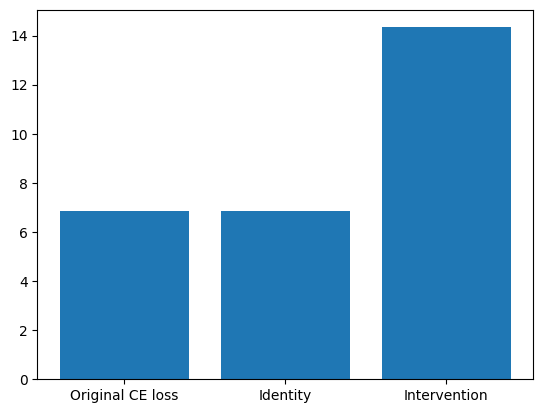

In [15]:
from matplotlib import pyplot as plt

plt.bar(['Original CE loss', 'Identity', 'Intervention'], [original_loss.detach().cpu().numpy(), iden_loss.detach().cpu().numpy(), za_loss.detach().cpu().numpy()])

### Sampling after intervention

We can use the `model.hooks()` context manager to sample from the model whilst applying pytorch hooks

In [16]:
import torch
def my_hook(x, hook):
    return -1.0*x
    
prompt = 'The capital of France is'

output = model.generate(prompt, max_new_tokens=16, temperature=0.0)
print('-- ORIGINAL OUTPUT --')
print(output)

with model.hooks(fwd_hooks=[("blocks.5.hook_resid_post", my_hook)]):
    output = model.generate(prompt, max_new_tokens=16, temperature=0.0)
print('-- MODIFIED OUTPUT --')
print(output)


  0%|          | 0/16 [00:00<?, ?it/s]

-- ORIGINAL OUTPUT --
The capital of France is now home to the world's largest concentration of the world's largest concentration of the


  0%|          | 0/16 [00:00<?, ?it/s]

-- MODIFIED OUTPUT --
The capital of France is-, ( M(-,…,,,,, (-,


## Indirect object identification (IOI)

This is the 'algorithmic' task of finding the indirect object token, in the sentence and predicting it as the next token.

E.g. in the prompt `"When John and Mary went to the shops, John gave a drink to"`:
* `John` is the subject
* `Mary` is the indirect object.

The task is predicting the IO `Mary` as the next token.

At a high-level, we're interested in understanding if/when/where specific capabilities (or factual knowledge) is isolated to particular subcomponents in the network.
During the lab, we're going to see tools (of increasing sophistication) to explore this!

### Example

We can see that gpt-2 correctly predicts `Mary` as the next token in the prompt `"When John and Mary went to the shops, John gave a drink to"`.

So, evidently gpt2-small is capable of executing the task!

In [17]:
prompt = "When John and Mary went to the shops, John gave a drink to"

utils.test_prompt(prompt, " Mary", model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'When', ' John', ' and', ' Mary', ' went', ' to', ' the', ' shops', ',', ' John', ' gave', ' a', ' drink', ' to']
Tokenized answer: [' Mary']


Performance on answer token:
Rank: 0        Logit: 17.81 Prob: 49.47% Token: | Mary|

Top 0th token. Logit: 17.81 Prob: 49.47% Token: | Mary|
Top 1th token. Logit: 16.89 Prob: 19.71% Token: | them|
Top 2th token. Logit: 16.01 Prob:  8.18% Token: | the|
Top 3th token. Logit: 15.02 Prob:  3.04% Token: | his|
Top 4th token. Logit: 14.71 Prob:  2.23% Token: | John|
Top 5th token. Logit: 14.71 Prob:  2.23% Token: | their|
Top 6th token. Logit: 14.29 Prob:  1.46% Token: | a|
Top 7th token. Logit: 14.07 Prob:  1.18% Token: | her|
Top 8th token. Logit: 13.70 Prob:  0.81% Token: | everyone|
Top 9th token. Logit: 13.40 Prob:  0.60% Token: | one|


Ranks of the answer tokens: [(' Mary', 0)]

### The question grounding our exploration now becomes: can we localize this to specific blocks, layers, or attention heads?

# [Task 1]

The first tasks are a gentle warmup.

**NOTE**: the warmup steps are trivially easy with LLM autocomplete! I'd highly recommend turning it off for this stage

This warmup has two goals: 
* To introduce useful utilities from TransformerLens for mechanistic interpretability, by way of intervening on specific layers to bring targeted changes to the output logits.
* To introduce **zero ablation**: setting intermediate activations at specific layer(s) to zero and seeing the effect on the output. This is a crude, imperfect measure of how "necessary" specific activations are for the task.
    * **note**: this is sometimes called a "noising" algorithm. We're starting with a working model, selectively removing activations, and seeing if it breaks the circuit.

<!--<img src="./images/warmup.png" width="300">-->
<img src="https://james-oldfield.github.io/ap-images/images/warmup.png" width="300">

> image credit: ChatGPT


We will be working with the same prompt in 'indirect object identification' format:

##### `"When John and Mary went to the shops, John gave a drink to"`

Here are a list of useful hooks that will be helpful for the first warmup task:

```python
hook_embed
hook_pos_embed
blocks.i.hook_resid_pre
blocks.i.ln1.hook_scale
blocks.i.ln1.hook_normalized
blocks.i.attn.hook_q
blocks.i.attn.hook_k
blocks.i.attn.hook_v
blocks.i.attn.hook_attn_scores
blocks.i.attn.hook_pattern
blocks.i.attn.hook_z
blocks.i.hook_attn_out
blocks.i.hook_resid_mid
blocks.i.ln2.hook_scale
blocks.i.ln2.hook_normalized
blocks.i.mlp.hook_pre
blocks.i.mlp.hook_post
blocks.i.hook_mlp_out
blocks.i.hook_resid_post
ln_final.hook_scale
ln_final.hook_normalized
```

### Exercise - Make an intervention to a single layer that leads to gpt2 predicting a token other than `Mary` as the next token</span>

> ```yaml
> Difficulty: 🔴🔴⚪⚪⚪
> Importance: 🔵🔵🔵⚪⚪
> ```

For this, you'll need to:
- Identify an appropriate layer (using the above list for guidance). Consider the various intermediate states in the Transformer model. Which layers' activations might be maximally important for the IOI task?
- Write an appropriate hook function -- how can we modify the activations at this layer to change the next token prediction? At this point, we just want to be maximally destructive, rather than bring about a targeted change.

If you are stuck at any point, it's perhaps worth revisiting the diagram of the residual stream from Anthropic above--from this we can see an overview of how components read and write to the residual stream.

In [18]:
def my_hook(x, hook):
    # TODO: modify x to change its values in whatever way necessary
    # note that currently this acts like an identity function -- we're simply returning the activations as-is
    return x
    
with model.hooks(fwd_hooks=[
    # TODO: define one appropriate layer to apply the intervention
    #("blocks.HOOK_ID_HERE", my_hook),
]):
    utils.test_prompt(prompt, " Mary", model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'When', ' John', ' and', ' Mary', ' went', ' to', ' the', ' shops', ',', ' John', ' gave', ' a', ' drink', ' to']
Tokenized answer: [' Mary']


Performance on answer token:
Rank: 0        Logit: 17.81 Prob: 49.47% Token: | Mary|

Top 0th token. Logit: 17.81 Prob: 49.47% Token: | Mary|
Top 1th token. Logit: 16.89 Prob: 19.71% Token: | them|
Top 2th token. Logit: 16.01 Prob:  8.18% Token: | the|
Top 3th token. Logit: 15.02 Prob:  3.04% Token: | his|
Top 4th token. Logit: 14.71 Prob:  2.23% Token: | John|
Top 5th token. Logit: 14.71 Prob:  2.23% Token: | their|
Top 6th token. Logit: 14.29 Prob:  1.46% Token: | a|
Top 7th token. Logit: 14.07 Prob:  1.18% Token: | her|
Top 8th token. Logit: 13.70 Prob:  0.81% Token: | everyone|
Top 9th token. Logit: 13.40 Prob:  0.60% Token: | one|


Ranks of the answer tokens: [(' Mary', 0)]

<details>
    <summary><strong>[solution]</strong></summary>

This is by no means the only solution. Here we add random noise to the later layers' residual stream, at all token positions!
    
```python
def my_hook(x, hook):
    return torch.randn_like(x)
    
with model.hooks(fwd_hooks=[
    ("blocks.7.hook_resid_post", my_hook),
]):
    utils.test_prompt(prompt, " Mary", model, prepend_bos=True)
```
        
</details>


### Exercise - Find **four** hook points at `blocks.{8..11}` whose activations can all be set to the zero vector (**"zero ablated"**) whilst preserving the IOI task capability for this prompt (i.e. `Mary` still comes next)

> ```yaml
> Difficulty: 🔴🔴🔴⚪⚪
> Importance: 🔵🔵🔵🔵⚪
> ```

For this, you'll need to:
- Identify appropriate layers, using the above list for guidance
- Write an appropriate hook function to set the activations to zero
    * Note that this gives us a very crude idea of the possible importance of each layer! As the notebook progresses through the ARENA tutorial, we'll see increasingly powerful ways of collecting such evidence.

<details>
    <summary>Hint 1</summary>
    
* Which categories of layers' activations are presumably *least* important for the IOI task? What kind of processing is relevant to the task? (factual recall, algorithmic reasoning, etc)
* How is information moved around in the self-attention layers? What about in the MLP layers? Which of these two kinds of mechanisms is most likely to be relevant to the IOI task? Perhaps think about how *you* would go about performing the IOI task yourself, if you were the residual stream representation of the final `"to"` token.
    
</details>

<details>
    <summary>Hint 2</summary>
    If you are still unsure, try to manually ablate each in turn:
    <ol>
    <li>the specified layers' <strong>attention</strong>'s activations</li>
    <li>the specified layers' <strong>MLP</strong>'s output activations</li>
    </ol>
    Does removing one category appear to be more destructive than another? It's sufficient to notice this, and move on!
    
</details>

Zero ablation overwrites a particular layers' activations to the zero vector during the forward pass. This is a crude way of seeing something like "how the network would have behaved, had that activation not taken on such a value?". This is weak, circumstantial evidence of whether these activations--in isolations--were *necessary* for the task

#### Optional: questions to think about

What is one potential drawback of using a vector of zeros as the replacement value, when simulating such a counterfactual. **What values might be more appropriate**?

<details>
    <summary>Hint</summary>
    Will the zero vector be "in-distribution"?
</details>

---

<img src="https://james-oldfield.github.io/ap-images/images/zero_ablate.png" width="300">

> image credit: ChatGPT

In [19]:
def my_hook(x, hook):
    # TODO: implement zero ablation (currently we are again using the identity function)
    return x

# TODO: define appropriate hook points at the 4 layers
with model.hooks(fwd_hooks=[
    # ("blocks.8.HOOK_POINT", my_hook),
    # ("blocks.9.HOOK_POINT", my_hook),
    # ("blocks.10.HOOK_POINT", my_hook),
    # ("blocks.11.HOOK_POINT", my_hook),
]):
    utils.test_prompt(prompt, " Mary", model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'When', ' John', ' and', ' Mary', ' went', ' to', ' the', ' shops', ',', ' John', ' gave', ' a', ' drink', ' to']
Tokenized answer: [' Mary']


Performance on answer token:
Rank: 0        Logit: 17.81 Prob: 49.47% Token: | Mary|

Top 0th token. Logit: 17.81 Prob: 49.47% Token: | Mary|
Top 1th token. Logit: 16.89 Prob: 19.71% Token: | them|
Top 2th token. Logit: 16.01 Prob:  8.18% Token: | the|
Top 3th token. Logit: 15.02 Prob:  3.04% Token: | his|
Top 4th token. Logit: 14.71 Prob:  2.23% Token: | John|
Top 5th token. Logit: 14.71 Prob:  2.23% Token: | their|
Top 6th token. Logit: 14.29 Prob:  1.46% Token: | a|
Top 7th token. Logit: 14.07 Prob:  1.18% Token: | her|
Top 8th token. Logit: 13.70 Prob:  0.81% Token: | everyone|
Top 9th token. Logit: 13.40 Prob:  0.60% Token: | one|


Ranks of the answer tokens: [(' Mary', 0)]

<details>
    <summary><strong>[solution]</strong></summary>

Zero-ablating the MLPs' outputs at these layers leaves the capability largely untouched! Why might this be?
    
```python
def my_hook(x, hook):
    # TODO: perform zero ablation
    return torch.zeros_like(x)

with model.hooks(fwd_hooks=[
    ("blocks.8.hook_mlp_out", my_hook),
    ("blocks.9.hook_mlp_out", my_hook),
    ("blocks.10.hook_mlp_out", my_hook),
    ("blocks.11.hook_mlp_out", my_hook),
]):
    utils.test_prompt(prompt, " Mary", model, prepend_bos=True)
```
        
</details>


### Exercise - Define one forward hook (and appropriate hook point) that will cause the model to output the subject `John` as the next token instead</span>

> ```yaml
> Difficulty: 🔴🔴🔴🔴⚪
> Importance: 🔵⚪⚪⚪⚪
> ```

**Note**: this task is not so much related to the IOI task itself. However, it should be a useful exercise in reasoning about different layers' activations and their influence at various points in the network.

It could be useful to recall the available hook points (for `i={0,...,n_layers}`):
<details>
<summary>See available hooks</summary>
<code>hook_embed
hook_pos_embed
blocks.i.hook_resid_pre
blocks.i.ln1.hook_scale
blocks.i.ln1.hook_normalized
blocks.i.attn.hook_q
blocks.i.attn.hook_k
blocks.i.attn.hook_v
blocks.i.attn.hook_attn_scores
blocks.i.attn.hook_pattern
blocks.i.attn.hook_z
blocks.i.hook_attn_out
blocks.i.hook_resid_mid
blocks.i.ln2.hook_scale
blocks.i.ln2.hook_normalized
blocks.i.mlp.hook_pre
blocks.i.mlp.hook_post
blocks.i.hook_mlp_out
blocks.i.hook_resid_post
ln_final.hook_scale
ln_final.hook_normalized</code>
</details>

<hr>

<details>
    <summary>Hint 1</summary>
    <ul>
    <li>At what point in the network do we have direct correspondence between the token dimensions and the original sequence of tokens, with their order preserved?</li>
    <li>It might be helpful here to recall the shape of the activations `[batch_size, n_tokens, dimension]` --  we can modify this tensor in any way we want</li>
    </ul>
</details>
<details>
    <summary>Hint 2</summary>
    <ul>
    <li>What about super early in the network? How can we swap activations around before any kind of cross-token interactions / positional information?</li>
    </ul>
</details>


In [20]:
def my_hook(x, hook):
    # TODO: manipulate the tensor x as appropriate
    return x
    
with model.hooks(fwd_hooks=[
    # TODO: define an appropriate hook point
    #("hook_HOOKPOINT", my_hook),
]):
    utils.test_prompt(prompt, " John", model)

Tokenized prompt: ['<|endoftext|>', 'When', ' John', ' and', ' Mary', ' went', ' to', ' the', ' shops', ',', ' John', ' gave', ' a', ' drink', ' to']
Tokenized answer: [' John']


Performance on answer token:
Rank: 4        Logit: 14.71 Prob:  2.23% Token: | John|

Top 0th token. Logit: 17.81 Prob: 49.47% Token: | Mary|
Top 1th token. Logit: 16.89 Prob: 19.71% Token: | them|
Top 2th token. Logit: 16.01 Prob:  8.18% Token: | the|
Top 3th token. Logit: 15.02 Prob:  3.04% Token: | his|
Top 4th token. Logit: 14.71 Prob:  2.23% Token: | John|
Top 5th token. Logit: 14.71 Prob:  2.23% Token: | their|
Top 6th token. Logit: 14.29 Prob:  1.46% Token: | a|
Top 7th token. Logit: 14.07 Prob:  1.18% Token: | her|
Top 8th token. Logit: 13.70 Prob:  0.81% Token: | everyone|
Top 9th token. Logit: 13.40 Prob:  0.60% Token: | one|


Ranks of the answer tokens: [(' John', 4)]

<details>
    <summary><strong>[solution]</strong></summary>

We can achieve this by swapping the pre-positional token embeddings:
    
```python
def my_hook(x, hook):
    # put the "john" token embedding into the subject position
    x[:, 10, :] = x[:, 4, :]
    return x
    
with model.hooks(fwd_hooks=[
    ("hook_embed", my_hook),
]):
    utils.test_prompt(prompt, " John", model)

# NOTE we can see this equivalent to modifying the input prompt to use the previous IO as new subject: 
with model.hooks(fwd_hooks=[]):
    prompt2 = 'When John and Mary went to the shops, Mary gave a drink to'
    utils.test_prompt(prompt2, " John", model)
```
        
</details>


## Part 2: Activation patching (in pairs, or solo)

So far, we've learned a little about a lot of the tools provided by `TransformerLens`, and seen one concrete tool for testing the importance of layers' activations--zero ablation--in exercise 2.

#### As the first section closes, it's worth reflecting a little on the following in turn:

1. Zero ablation is a crude test of the necessity of the activations for the IOI task (why?)
    * Caveat: the zero vector will be out-of-distribution, and may risk destroying the ability of the model to perform the task for this (unrelated) reason alone!
4. What might a test for sufficiency for a "layers' activations' importance on the IOI task" look like? What properties might it have, in terms of changes to model outputs?
    * Hint: when using zero ablation to probe for the importance of activations, the process is: "start with the model producing the *correct* output, then modify the activations such that the output is *incorrect*" -- can we re-order this setup to lead to the above?

We're going to see some partial answers to the latter question next through **activation patching** for the IOI task--a kind of "denoising" process

From here on out, we're going to be using the excellent ARENA tutorials! You can find out more about ARENA below:

[https://arena-chapter1-transformer-interp.streamlit.app/](https://arena-chapter1-transformer-interp.streamlit.app/)

The rest of this notebook is almost entirely from the above tutorial, verbatim. Although we've removed some of the later parts we're not going to be looking at given time constraints, and removed some text which references findings in earlier ARENA tutorials in an attempt to make this self-contained. We've also removed the suggestion for amount of time to spend on each task, given we've speed-ran a lot of the basics. Note that the comments are written in first person from the POV of the original ARENA tutorials' author(s)!

## Suggestions on how to approach the notebook

To restate, we again encourage you to bear the following two things in mind:
1. Optimize for depth over breadth -- there is far too much content here to digest meaningfully in 2-3 hours.
2. The purpose of this tutorial is to get hands on experience with using `TransformerLens` for making interventions, and seeing which techniques provide us with what kinds of evidence.
    * For today, we are not so concerned about learning the intricacies and details of the particular components and types of attention heads responsible for the IOI task--this is primarily a task to ground our exploration.

Where we feel the need to add our own additional comments, we have added the following boxes throughout:

<div style="
  border-left: 6px solid #2e8b57;
  background: linear-gradient(90deg, #f6fff8 0%, #f0fff4 100%);
  padding: 1rem 1.25rem;
  margin: 1.5rem 0;
  border-radius: 10px;
  box-shadow: 0 2px 6px rgba(0,0,0,0.05);
">
  <h2 style="
    color: #2e8b57;
    margin-top: 0;
    margin-bottom: 0.5rem;
    letter-spacing: 0.5px;
  ">AISAA Note</h2>
  <p style="
    margin: 0;
    color: #2f3e46;
    line-height: 1.5;
  ">
    [here contains any useful additional information relevant to the lab session!]
  </p>
</div>

With that noted, let's jump in to the (abridged) [ARENA](https://arena-chapter1-transformer-interp.streamlit.app/) tutorial below!

<img src="https://raw.githubusercontent.com/info-arena/ARENA_img/main/misc/headers/header-14-1.png" width="350">

# Introduction

This notebook / document is built around the [Interpretability in the Wild](https://arxiv.org/abs/2211.00593) paper, in which the authors aim to understand the **indirect object identification circuit** in GPT-2 small. This circuit is resposible for the model's ability to complete sentences like `"John and Mary went to the shops, John gave a bag to"` with the correct token "`" Mary"`.

It is loosely divided into different sections, each one with their own flavour. Sections 1, 2 & 3 are derived from Neel Nanda's notebook [Exploratory_Analysis_Demo](https://colab.research.google.com/github/TransformerLensOrg/TransformerLens/blob/main/demos/Exploratory_Analysis_Demo.ipynb#scrollTo=WXktSe0CvBdh). The flavour of these exercises is experimental and loose, with a focus on demonstrating what exploratory analysis looks like in practice with the transformerlens library. They skimp on rigour, and instead try to speedrun the process of finding suggestive evidence for this circuit. The code and exercises are simple and generic, but accompanied with a lot of detail about what each stage is doing, and why (plus several optional details and tangents).

*Note - if you find yourself getting frequent CUDA memory errors, you can periodically call `torch.cuda.empty_cache()` to [free up some memory](https://stackoverflow.com/questions/57858433/how-to-clear-gpu-memory-after-pytorch-model-training-without-restarting-kernel).*

Each exercise will have a difficulty and importance rating out of 5, and sometimes a short annotation.

## The purpose / structure of these exercises

At a surface level, these exercises are designed to take you through the indirect object identification circuit. But it's also designed to make you a better interpretability researcher! As a result, most exercises will be doing a combination of:

1. Showing you some new feature/component of the circuit, and
2. Teaching you how to use tools and interpret results in a broader mech interp context.

A key idea to have in mind during these exercises is the **spectrum from simpler, more exploratory tools to more rigoruous, complex tools**. On the simpler side, you have something like inspecting attention patterns, which can give a decent (but sometimes misleading) picture of what an attention head is doing. These should be some of the first tools you reach for, and you should be using them a lot even before you have concrete hypotheses about a circuit. On the more rigorous side, you have something like path patching, which is a pretty rigorous and effortful tool that is best used when you already have reasonably concrete hypotheses about a circuit (note: which we won't be covering in the AISAA lab!). As we go through the exercises, we'll transition from left to right along this spectrum.

## The IOI task

The first step when trying to reverse engineer a circuit in a model is to identify *what* capability we want to reverse engineer. Indirect Object Identification is a task studied in Redwood Research's excellent [Interpretability in the Wild](https://arxiv.org/abs/2211.00593) paper (see [Neel Nanda's interview with the authors](https://www.youtube.com/watch?v=gzwj0jWbvbo) or [Kevin Wang's Twitter thread](https://threadreaderapp.com/thread/1587601532639494146.html) for an overview). The task is to complete sentences like "When Mary and John went to the store, John gave a drink to" with " Mary" rather than " John".

In the paper they rigorously reverse engineer a 26 head circuit, with 7 separate categories of heads used to perform this capability. The circuit they found roughly breaks down into three parts:

1. Identify what names are in the sentence
2. Identify which names are duplicated
3. Predict the name that is *not* duplicated

Why was this task chosen? The authors give a very good explanation for their choice in their [video walkthrough of their paper](https://www.youtube.com/watch?v=gzwj0jWbvbo), which you are encouraged to watch. To be brief, some of the reasons were:

* This is a fairly common grammatical structure, so we should expect the model to build some circuitry for solving it quite early on (after it's finished with all the more basic stuff, like n-grams, punctuation, induction, and simpler grammatical structures than this one).
* It's easy to measure: the model always puts a much higher probability on the IO and S tokens (i.e. `" Mary"` and `" John"`) than any others, and this is especially true once the model starts being stripped down to the core part of the circuit we're studying. So we can just take the logit difference between these two tokens, and use this as a metric for how well the model can solve the task.
* It is a crisp and well-defined task, so less likely to be solved in terms of memorisation of a large bag of heuristics (unlike e.g. tasks like "predict that the number `n+1` will follow `n`, which as Neel mentions in the video walkthrough is actually much more annoying and subtle than it first seems!).

A terminology note: `IO` will refer to the indirect object (in the example, `" Mary"`), `S1` and `S2` will refer to the two instances of the subject token (i.e. `" John"`), and `end` will refer to the end token `" to"` (because this is the position we take our prediction from, and we don't care about any tokens after this point). We will also sometimes use `S` to refer to the identity of the subject token (rather than referring to the first or second instance in particular).

## Keeping track of your guesses & predictions

There's a lot to keep track of in these exercises as we work through them. You'll be exposed to new functions and modules from transformerlens, new ways to causally intervene in models, all the while building up your understanding of how the IOI task is performed. The notebook starts off exploratory in nature (lots of plotting and investigation), and gradually moves into more technical details, refined analysis, and replication of the paper's results, as we improve our understanding of the IOI circuit. You are recommended to keep a document or page of notes nearby as you go through these exercises, so you can keep track of the main takeaways from each section, as well as your hypotheses for how the model performs the task, and your ideas for how you might go off and test these hypotheses on your own if the notebook were to suddenly end.

If you are feeling extremely confused at any point, you can come back to the dropdown below, which contains diagrams explaining how the circuit works. There is also an accompanying intuitive explanation which you might find more helpful. However, I'd recommend you try and go through the notebook unassisted before looking at these.

<div style="
  border-left: 6px solid #2e8b57;
  background: linear-gradient(90deg, #f6fff8 0%, #f0fff4 100%);
  padding: 1rem 1.25rem;
  margin: 1.5rem 0;
  border-radius: 10px;
  box-shadow: 0 2px 6px rgba(0,0,0,0.05);
">
  <h2 style="
    color: #2e8b57;
    margin-top: 0;
    margin-bottom: 0.5rem;
    letter-spacing: 0.5px;
  ">AISAA Note</h2>
  <p style="
    margin: 0;
    color: #2f3e46;
    line-height: 1.5;
  ">
  We strongly suggest you do not look at the additional explanations in the dropdowns directly below until right at the end (if you are particularly interested in the IOI circuit itself) -- this threatens to be an information overload in our limited time!
  </p>
</div>

---

<details>
<summary>Intuitive explanation of IOI circuit</summary>

First, let's start with an analogy for how transformers work (you can skip this if you've already read [my post](https://www.lesswrong.com/posts/euam65XjigaCJQkcN/an-analogy-for-understanding-transformers)). Imagine a line of people, who can only look forward. Each person has a token written on their chest, and their goal is to figure out what token the person in front of them is holding. Each person is allowed to pass a question backwards along the line (not forwards), and anyone can choose to reply to that question by passing information forwards to the person who asked. In this case, the sentence is `"When Mary and John went to the store, John gave a drink to Mary"`. You are the person holding the `" to"` token, and your goal is to figure out that the person in front of him has the `" Mary"` token.

To be clear about how this analogy relates to transformers:
* Each person in the line represents a vector in the residual stream. Initially they just store their own token, but they accrue more information as they ask questions and receive answers (i.e. as components write to the residual stream)
* The operation of an attention head is represented by a question & answer:
    * The person who asks is the destination token, the people who answer are the source tokens
    * The question is the query vector
    * The information *which determines who answers the question* is the key vector
    * The information *which gets passed back to the original asker* is the value vector

Now, here is how the IOI circuit works in this analogy. Each bullet point represents a class of attention heads.

* The person with the second `" John"` token asks the question "does anyone else hold the name `" John"`?". They get a reply from the first `" John"` token, who also gives him their location. So he now knows that `" John"` is repeated, and he knows that the first `" John"` token is 4th in the sequence.
    * These are *Duplicate Token Heads*
* You ask the question "which names are repeated?", and you get an answer from the person holding the second `" John"` token. You now also know that `" John"` is repeated, and where the first `" John"` token is.
    * These are *S-Inhibition Heads*
* You ask the question "does anyone have a name that isn't `" John"`, and isn't at the 4th position in the sequence?". You get a reply from the person holding the `" Mary"` token, who tells you that they have name `" Mary"`. You use this as your prediction.
    * These are *Name Mover Heads*

This is a fine first-pass understanding of how the circuit works. A few other features:

* The person after the first `" John"` (holding `" went"`) had previously asked about the identity of the person behind him. So he knows that the 4th person in the sequence holds the `" John"` token, meaning he can also reply to the question of the person holding the second `" John"` token. *(previous token heads / induction heads)*
    * This might not seem necessary, but since previous token heads / induction heads are just a pretty useful thing to have in general, it makes sense that you'd want to make use of this information!
* If for some reason you forget to ask the question "does anyone have a name that isn't `" John"`, and isn't at the 4th position in the sequence?", then you'll have another chance to do this.
    * These are *(Backup Name Mover Heads)*
    * Their existance might be partly because transformers are trained with **dropout**. This can make them "forget" things, so it's important to have a backup method for recovering that information!
* You want to avoid overconfidence, so you also ask the question "does anyone have a name that isn't `" John"`, and isn't at the 4th position in the sequence?" another time, in order to ***anti-***predict the response that you get from this question. *(negative name mover heads)*
    * Yes, this is as weird as it sounds! The authors speculate that these heads "hedge" the predictions, avoiding high cross-entropy loss when making mistakes.

</details>

<details>
<summary>Diagram 1 (simple)</summary>

<img src="https://raw.githubusercontent.com/info-arena/ARENA_img/main/misc/ioi-main-simple-a.png" width="1000">

</details>

<details>
<summary>Diagram 2 (complex)</summary>

<img src="https://raw.githubusercontent.com/info-arena/ARENA_img/main/misc/ioi-main-full-d.png" width="1250">

</details>

## Content & Learning Objectives

### 1️⃣ Model & Task Setup

In this section you'll set up your model, and see how to analyse its performance on the IOI task. You'll also learn how to measure it's performance using tools like logit difference.

> ##### Learning Objectives
>
> * Understand the IOI task, and why the authors chose to study it
> * Build functions to demonstrate the model's performance on this task

### 2️⃣ Logit Attribution

Next, you'll move on to some component attribution: evaluating the importance of each model component for the IOI task. However, this type of analysis is limited to measuring a component's direct effect, as opposed to indirect effect - we'll measure the latter in future sections.

> ##### Learning Objectives
>
> * Perform direct logit attribution to figure out which heads are writing to the residual stream in a significant way
> * Learn how to use different transformerlens helper functions, which decompose the residual stream in different ways

### 3️⃣ Activation Patching

We introduce one of the two important patching tools you'll use during this section: **activation patching**. This can be used to discover which components of a model are important for a particular task, by measuring the changes in our previously-defined task metrics when you patch into a particular component with corrupted input.

> ##### Learning Objectives
>
> * Understand the idea of activation patching, and how it can be used
>     * Implement some of the activation patching helper functinos in transformerlens from scratch (i.e. using hooks)
> * Use activation patching to track the layers & sequence positions in the residual stream where important information is stored and processed
> * By the end of this section, you should be able to draw a rough sketch of the IOI circuit

## Setup code

In [21]:
import os
import sys
from pathlib import Path

IN_COLAB = "google.colab" in sys.modules

chapter = "chapter1_transformer_interp"
repo = "ARENA_3.0"
branch = "main"

# Install dependencies
try:
    import transformer_lens
except:
    %pip install transformer_lens==2.11.0 einops jaxtyping git+https://github.com/callummcdougall/CircuitsVis.git#subdirectory=python

# Get root directory, handling 3 different cases: (1) Colab, (2) notebook not in ARENA repo, (3) notebook in ARENA repo
root = (
    "/content"
    if IN_COLAB
    else "./"
    if repo not in os.getcwd()
    else str(next(p for p in Path.cwd().parents if p.name == repo))
)

if Path(root).exists() and not Path(f"{root}/{chapter}").exists():
    if not IN_COLAB:
        #!sudo apt-get install unzip # <- you *may* need to uncomment this, if running locally.
        %pip install jupyter ipython --upgrade

    if not os.path.exists(f"{root}/{chapter}"):
        !wget -P {root} https://github.com/callummcdougall/ARENA_3.0/archive/refs/heads/{branch}.zip
        !unzip {root}/{branch}.zip '{repo}-{branch}/{chapter}/exercises/*' -d {root}
        !mv {root}/{repo}-{branch}/{chapter} {root}/{chapter}
        !rm {root}/{branch}.zip
        !rmdir {root}/{repo}-{branch}


if f"{root}/{chapter}/exercises" not in sys.path:
    sys.path.append(f"{root}/{chapter}/exercises")

os.chdir(f"{root}/{chapter}/exercises")

In [22]:
import re
import sys
from functools import partial
from itertools import product
from pathlib import Path
from typing import Callable, Literal

import circuitsvis as cv
import einops
import numpy as np
import plotly.express as px
import torch as t
from IPython.display import HTML, display
from jaxtyping import Bool, Float, Int
from rich import print as rprint
from rich.table import Column, Table
from torch import Tensor
from tqdm.notebook import tqdm
from transformer_lens import ActivationCache, HookedTransformer, utils
from transformer_lens.components import MLP, Embed, LayerNorm, Unembed
from transformer_lens.hook_points import HookPoint

t.set_grad_enabled(False)
device = t.device(
    "mps" if t.backends.mps.is_available() else "cuda" if t.cuda.is_available() else "cpu"
)

# Make sure exercises are in the path
chapter = "chapter1_transformer_interp"
section = "part41_indirect_object_identification"
root_dir = next(p for p in Path.cwd().parents if (p / chapter).exists())
exercises_dir = root_dir / chapter / "exercises"
section_dir = exercises_dir / section

import part41_indirect_object_identification.tests as tests
from plotly_utils import bar, imshow, line, scatter

MAIN = __name__ == "__main__"

# 1️⃣ Model & Task Setup

> ##### Learning Objectives
>
> * Understand the IOI task, and why the authors chose to study it
> * Build functions to demonstrate the model's performance on this task

## Loading our model

The first step is to load in our model, GPT-2 Small, a 12 layer and 80M parameter transformer with `HookedTransformer.from_pretrained`. The various flags are simplifications that preserve the model's output but simplify its internals.

In [23]:
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

Loaded pretrained model gpt2-small into HookedTransformer


<details>
<summary>Note on <code>refactor_factored_attn_matrices</code> (optional)</summary>

This argument means we redefine the matrices $W_Q$, $W_K$, $W_V$ and $W_O$ in the model (without changing the model's actual behaviour).

For example, we know that instead of working with $W_Q$ and $W_K$ individually, the only matrix we actually need to use in the model is the low-rank matrix $W_Q W_K^T$ (note that I'm using the convention of matrix multiplication on the right, which matches the code in transformerlens and previous exercises in this series, but doesn't match Anthropic's Mathematical Frameworks paper). So if we perform singular value decomposition $W_Q W_K^T = U S V^T$, then we see that we can just as easily define $W_Q = U \sqrt{S}$ and $W_K = V \sqrt{S}$ and use these instead. This means that $W_Q$ and $W_K$ both have orthogonal columns with matching norms. You can investigate this yourself (e.g. using the code below). This is arguably a more interpretable setup, because now there's no obvious asymmetry between the keys and queries.

There's also some fiddlyness with how biases are handled in this factorisation, which is why the comments above don't hold absolutely (see the documentation for more info).

```python
# Show column norms are the same (except first few, for fiddly bias reasons)
line([model.W_Q[0, 0].pow(2).sum(0), model.W_K[0, 0].pow(2).sum(0)])
# Show columns are orthogonal (except first few, again)
W_Q_dot_products = einops.einsum(
    model.W_Q[0, 0], model.W_Q[0, 0], "d_model d_head_1, d_model d_head_2 -> d_head_1 d_head_2"
)
imshow(W_Q_dot_products)
```

In a similar way, since $W_{OV} = W_V W_O = U S V^T$, we can define $W_V = U S$ and $W_O = V^T$. This is arguably a more interpretable setup, because now $W_O$ is just a rotation, and doesn't change the norm, so $z$ has the same norm as the result of the head.
</details>

<details>
<summary>Note on <code>fold_ln</code>, <code>center_unembed</code> and <code>center_writing_weights</code> (optional)</summary>

See link [here](https://github.com/neelnanda-io/TransformerLens/blob/main/further_comments.md#what-is-layernorm-folding-fold_ln) for comments.
</details>

<div style="
  border-left: 6px solid #2e8b57;
  background: linear-gradient(90deg, #f6fff8 0%, #f0fff4 100%);
  padding: 1rem 1.25rem;
  margin: 1.5rem 0;
  border-radius: 10px;
  box-shadow: 0 2px 6px rgba(0,0,0,0.05);
">
  <h2 style="
    color: #2e8b57;
    margin-top: 0;
    margin-bottom: 0.5rem;
    letter-spacing: 0.5px;
  ">AISAA Note</h2>
  <p style="
    margin: 0;
    color: #2f3e46;
    line-height: 1.5;
  ">
  The way LayerNorm is handled (and decomposed to aid interpretability) is a rather interesting technical tangent, if you fancied going down a bit of a rabbit hole!
      
  </p>
</div>

The next step is to verify that the model can *actually* do the task! Here we use `utils.test_prompt`, and see that the model is significantly better at predicting Mary than John!

<details><summary>Asides</summary>

Note: If we were being careful, we'd want to run the model on a range of prompts and find the average performance. We'll do more stuff like this in the fourth section (when we try to replicate some of the paper's results, and take a more rigorous approach).

`prepend_bos` is a flag to add a BOS (beginning of sequence) to the start of the prompt. GPT-2 was not trained with this, but I find that it often makes model behaviour more stable, as the first token is treated weirdly.
</details>

In [24]:
# Here is where we test on a single prompt
# Result: 70% probability on Mary, as we expect

example_prompt = "After John and Mary went to the store, John gave a bottle of milk to"
example_answer = " Mary"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'After', ' John', ' and', ' Mary', ' went', ' to', ' the', ' store', ',', ' John', ' gave', ' a', ' bottle', ' of', ' milk', ' to']
Tokenized answer: [' Mary']


Performance on answer token:
Rank: 0        Logit: 18.09 Prob: 70.07% Token: | Mary|

Top 0th token. Logit: 18.09 Prob: 70.07% Token: | Mary|
Top 1th token. Logit: 15.38 Prob:  4.67% Token: | the|
Top 2th token. Logit: 15.35 Prob:  4.54% Token: | John|
Top 3th token. Logit: 15.25 Prob:  4.11% Token: | them|
Top 4th token. Logit: 14.84 Prob:  2.73% Token: | his|
Top 5th token. Logit: 14.06 Prob:  1.24% Token: | her|
Top 6th token. Logit: 13.54 Prob:  0.74% Token: | a|
Top 7th token. Logit: 13.52 Prob:  0.73% Token: | their|
Top 8th token. Logit: 13.13 Prob:  0.49% Token: | Jesus|
Top 9th token. Logit: 12.97 Prob:  0.42% Token: | him|


Ranks of the answer tokens: [(' Mary', 0)]

We now want to find a reference prompt to run the model on. Even though our ultimate goal is to reverse engineer how this behaviour is done in general, often the best way to start out in mechanistic interpretability is by zooming in on a concrete example and understanding it in detail, and only *then* zooming out and verifying that our analysis generalises. In section 3, we'll work with a dataset similar to the one used by the paper authors, but this probably wouldn't be the first thing we reached for if we were just doing initial investigations.

We'll run the model on 4 instances of this task, each prompt given twice - one with the first name as the indirect object, one with the second name. To make our lives easier, we'll carefully choose prompts with single token names and the corresponding names in the same token positions.

<details><summary>Aside on tokenization</summary>

We want models that can take in arbitrary text, but models need to have a fixed vocabulary. So the solution is to define a vocabulary of **tokens** and to deterministically break up arbitrary text into tokens. Tokens are, essentially, subwords, and are determined by finding the most frequent substrings - this means that tokens vary a lot in length and frequency!

Tokens are a *massive* headache and are one of the most annoying things about reverse engineering language models... Different names will be different numbers of tokens, different prompts will have the relevant tokens at different positions, different prompts will have different total numbers of tokens, etc. Language models often devote significant amounts of parameters in early layers to convert inputs from tokens to a more sensible internal format (and do the reverse in later layers). You really, really want to avoid needing to think about tokenization wherever possible when doing exploratory analysis (though, of course, it's relevant later when trying to flesh out your analysis and make it rigorous!). HookedTransformer comes with several helper methods to deal with tokens: `to_tokens, to_string, to_str_tokens, to_single_token, get_token_position`

**Exercise:** I recommend using `model.to_str_tokens` to explore how the model tokenizes different strings. In particular, try adding or removing spaces at the start, or changing capitalization - these change tokenization!</details>

In [25]:
prompt_format = [
    "When John and Mary went to the shops,{} gave the bag to",
    "When Tom and James went to the park,{} gave the ball to",
    "When Dan and Sid went to the shops,{} gave an apple to",
    "After Martin and Amy went to the park,{} gave a drink to",
]
name_pairs = [
    (" Mary", " John"),
    (" Tom", " James"),
    (" Dan", " Sid"),
    (" Martin", " Amy"),
]

# Define 8 prompts, in 4 groups of 2 (with adjacent prompts having answers swapped)
prompts = [
    prompt.format(name)
    for (prompt, names) in zip(prompt_format, name_pairs)
    for name in names[::-1]
]
# Define the answers for each prompt, in the form (correct, incorrect)
answers = [names[::i] for names in name_pairs for i in (1, -1)]
# Define the answer tokens (same shape as the answers)
answer_tokens = t.concat([model.to_tokens(names, prepend_bos=False).T for names in answers])

rprint(prompts)
rprint(answers)
rprint(answer_tokens)

table = Table("Prompt", "Correct", "Incorrect", title="Prompts & Answers:")

for prompt, answer in zip(prompts, answers):
    table.add_row(prompt, repr(answer[0]), repr(answer[1]))

rprint(table)

[
    'When John and Mary went to the shops, John gave the bag to',
    'When John and Mary went to the shops, Mary gave the bag to',
    'When Tom and James went to the park, James gave the ball to',
    'When Tom and James went to the park, Tom gave the ball to',
    'When Dan and Sid went to the shops, Sid gave an apple to',
    'When Dan and Sid went to the shops, Dan gave an apple to',
    'After Martin and Amy went to the park, Amy gave a drink to',
    'After Martin and Amy went to the park, Martin gave a drink to'
]

[
    (' Mary', ' John'),
    (' John', ' Mary'),
    (' Tom', ' James'),
    (' James', ' Tom'),
    (' Dan', ' Sid'),
    (' Sid', ' Dan'),
    (' Martin', ' Amy'),
    (' Amy', ' Martin')
]

tensor([[ 5335,  1757],
        [ 1757,  5335],
        [ 4186,  3700],
        [ 3700,  4186],
        [ 6035, 15686],
        [15686,  6035],
        [ 5780, 14235],
        [14235,  5780]], device='cuda:0')

                                   Prompts & Answers:                                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Prompt                                                        ┃ Correct   ┃ Incorrect ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━┩
│ When John and Mary went to the shops, John gave the bag to    │ ' Mary'   │ ' John'   │
│ When John and Mary went to the shops, Mary gave the bag to    │ ' John'   │ ' Mary'   │
│ When Tom and James went to the park, James gave the ball to   │ ' Tom'    │ ' James'  │
│ When Tom and James went to the park, Tom gave the ball to     │ ' James'  │ ' Tom'    │
│ When Dan and Sid went to the shops, Sid gave an apple to      │ ' Dan'    │ ' Sid'    │
│ When Dan and Sid went to the shops, Dan gave an apple to      │ ' Sid'    │ ' Dan'    │
│ After Martin and Amy went to the park, Amy gave a drink to    │ ' Martin' │ ' Amy'    │
│ After Martin and Amy went to the park, Martin gave a drink to │ ' Amy'    │ ' Martin' │
└───────────────────────────────────────────────────────────────┴───────────┴───────────┘

<details>
<summary>Aside - the <code>rich</code> library</summary>

The outputs above were created by `rich`, a fun library which prints things in nice formats. It has functions like `rich.table.Table`, which are very easy to use but can produce visually clear outputs which are sometimes useful.

You can also color the columns of a table, by using the `rich.table.Column` argument with the `style` parameter:

```python
cols = [
    "Prompt",
    Column("Correct", style="rgb(0,200,0) bold"),
    Column("Incorrect", style="rgb(255,0,0) bold"),
]
table = Table(*cols, title="Prompts & Answers:")

for prompt, answer in zip(prompts, answers):
    table.add_row(prompt, repr(answer[0]), repr(answer[1]))

rprint(table)
```
</details>

We now run the model on these prompts and use `run_with_cache` to get both the logits and a cache of all internal activations for later analysis.

In [26]:
tokens = model.to_tokens(prompts, prepend_bos=True)
# Move the tokens to the GPU
tokens = tokens.to(device)
# Run the model and cache all activations
original_logits, cache = model.run_with_cache(tokens)

In [27]:
utils.test_prompt('When Tom and James went to the park, James gave the ball to', ' Tom', model)

Tokenized prompt: ['<|endoftext|>', 'When', ' Tom', ' and', ' James', ' went', ' to', ' the', ' park', ',', ' James', ' gave', ' the', ' ball', ' to']
Tokenized answer: [' Tom']


Performance on answer token:
Rank: 0        Logit: 15.88 Prob: 40.01% Token: | Tom|

Top 0th token. Logit: 15.88 Prob: 40.01% Token: | Tom|
Top 1th token. Logit: 14.44 Prob:  9.44% Token: | the|
Top 2th token. Logit: 14.12 Prob:  6.88% Token: | his|
Top 3th token. Logit: 13.34 Prob:  3.15% Token: | them|
Top 4th token. Logit: 13.26 Prob:  2.90% Token: | a|
Top 5th token. Logit: 13.17 Prob:  2.66% Token: | James|
Top 6th token. Logit: 12.76 Prob:  1.76% Token: | their|
Top 7th token. Logit: 12.39 Prob:  1.22% Token: | him|
Top 8th token. Logit: 11.64 Prob:  0.58% Token: | John|
Top 9th token. Logit: 11.55 Prob:  0.52% Token: | George|


Ranks of the answer tokens: [(' Tom', 0)]

We'll later be evaluating how model performance differs upon performing various interventions, so it's useful to have a metric to measure model performance. Our metric here will be the **logit difference**, the difference in logit between the indirect object's name and the subject's name (eg, `logit(Mary) - logit(John)`).

### Exercise - implement the performance evaluation function

> ```yaml
> Difficulty: 🔴🔴🔴⚪⚪
> Importance: 🔵🔵🔵🔵⚪
>
> It's important to understand exactly what this function is computing, and why it matters.
> ```

This function should take in your model's logit output (shape `(batch, seq, d_vocab)`), and the array of answer tokens (shape `(batch, 2)`, containing the token ids of correct and incorrect answers respectively for each sequence), and return the logit difference as described above. If `per_prompt` is False, then it should take the mean over the batch dimension, if not then it should return an array of length `batch`.

In [ ]:
def logits_to_ave_logit_diff(
    logits: Float[Tensor, "batch seq d_vocab"],
    answer_tokens: Int[Tensor, "batch 2"] = answer_tokens,
    per_prompt: bool = False,
) -> Float[Tensor, "*batch"]:
    """
    Returns logit difference between the correct and incorrect answer.

    If per_prompt=True, return the array of differences rather than the average.
    """
    raise NotImplementedError()


tests.test_logits_to_ave_logit_diff(logits_to_ave_logit_diff)

original_per_prompt_diff = logits_to_ave_logit_diff(original_logits, answer_tokens, per_prompt=True)
print("Per prompt logit difference:", original_per_prompt_diff)
original_average_logit_diff = logits_to_ave_logit_diff(original_logits, answer_tokens)
print("Average logit difference:", original_average_logit_diff)

cols = [
    "Prompt",
    Column("Correct", style="rgb(0,200,0) bold"),
    Column("Incorrect", style="rgb(255,0,0) bold"),
    Column("Logit Difference", style="bold"),
]
table = Table(*cols, title="Logit differences")

for prompt, answer, logit_diff in zip(prompts, answers, original_per_prompt_diff):
    table.add_row(prompt, repr(answer[0]), repr(answer[1]), f"{logit_diff.item():.3f}")

rprint(table)

<details><summary>Solution</summary>

```python
def logits_to_ave_logit_diff(
    logits: Float[Tensor, "batch seq d_vocab"],
    answer_tokens: Int[Tensor, "batch 2"] = answer_tokens,
    per_prompt: bool = False,
) -> Float[Tensor, "*batch"]:
    """
    Returns logit difference between the correct and incorrect answer.

    If per_prompt=True, return the array of differences rather than the average.
    """
    # Only the final logits are relevant for the answer
    final_logits: Float[Tensor, "batch d_vocab"] = logits[:, -1, :]
    # Get the logits corresponding to the indirect object / subject tokens respectively
    answer_logits: Float[Tensor, "batch 2"] = final_logits.gather(dim=-1, index=answer_tokens)
    # Find logit difference
    correct_logits, incorrect_logits = answer_logits.unbind(dim=-1)
    answer_logit_diff = correct_logits - incorrect_logits
    return answer_logit_diff if per_prompt else answer_logit_diff.mean()
```
</details>

# 2️⃣ Logit Attribution

> ##### Learning Objectives
>
> * Perform direct logit attribution to figure out which heads are writing to the residual stream in a significant way
> * Learn how to use different transformerlens helper functions, which decompose the residual stream in different ways

## Direct Logit Attribution

The easiest part of the model to understand is the output - this is what the model is trained to optimize, and so it can always be directly interpreted! Often the right approach to reverse engineering a circuit is to start at the end, understand how the model produces the right answer, and to then work backwards (you will have seen this if you went through the balanced bracket classifier task, and in fact if you did then this section will probably be quite familiar to you and you should feel free to just skim through it). The main technique used to do this is called **direct logit attribution**

**Background:** The central object of a transformer is the **residual stream**. This is the sum of the outputs of each layer and of the original token and positional embedding. Importantly, this means that any linear function of the residual stream can be perfectly decomposed into the contribution of each layer of the transformer. Further, each attention layer's output can be broken down into the sum of the output of each head (See [A Mathematical Framework for Transformer Circuits](https://transformer-circuits.pub/2021/framework/index.html) for details), and each MLP layer's output can be broken down into the sum of the output of each neuron (and a bias term for each layer).

The logits of a model are `logits=Unembed(LayerNorm(final_residual_stream))`. The Unembed is a linear map, and LayerNorm is approximately a linear map, so we can decompose the logits into the sum of the contributions of each component, and look at which components contribute the most to the logit of the correct token! This is called **direct logit attribution**. Here we look at the direct attribution to the logit difference!

### Background and motivation of the logit difference

Logit difference is actually a *really* nice and elegant metric and is a particularly nice aspect of the setup of Indirect Object Identification. In general, there are two natural ways to interpret the model's outputs: the output logits, or the output log probabilities (or probabilities).

The logits are much nicer and easier to understand, as noted above. However, the model is trained to optimize the cross-entropy loss (the average of log probability of the correct token). This means it does not directly optimize the logits, and indeed if the model adds an arbitrary constant to every logit, the log probabilities are unchanged.

But we have:

```
log_probs == logits.log_softmax(dim=-1) == logits - logsumexp(logits)
```

and because they differ by a constant, we have:

```
log_probs(" Mary") - log_probs(" John") = logits(" Mary") - logits(" John")
```

- the ability to add an arbitrary constant cancels out!

<details>
<summary>Technical details (if this equivalence doesn't seem obvious to you)</summary>

Let $\vec{\textbf{x}}$ be the logits, $\vec{\textbf{L}}$ be the log probs, and $\vec{\textbf{p}}$ be the probs. Then we have the following relations:

$$
p_i = \operatorname{softmax}(\vec{\textbf{x}})_i = \frac{e^{x_i}}{\sum_{i=1}^n e^{x_i}}
$$

and:

$$
L_i = \log p_i
$$

Combining these, we get:

$$
L_i = \log \frac{e^{x_i}}{\sum_{j=1}^n e^{x_j}} = x_i - \log \sum_{j=1}^n e^{x_j}
$$

Notice that the sum term on the right hand side is the same for all $i$, so we get:

$$
L_i - L_j = x_i - x_j
$$

in other words, the logit diff $x_i - x_j$ is the same as the log prob diff. This motivates the choice of logit diff as our choice of metric (since the model is directly training to make the log prob of the correct token large, and all other log probs small).

</details>

Further, the metric helps us isolate the precise capability we care about - figuring out *which* name is the Indirect Object. There are many other components of the task - deciding whether to return an article (the) or pronoun (her) or name, realising that the sentence wants a person next at all, etc. By taking the logit difference we control for all of that.

Our metric is further refined, because each prompt is repeated twice, for each possible indirect object. This controls for irrelevant behaviour such as the model learning that John is a more frequent token than Mary (this actually happens! The final layernorm bias increases the John logit by 1 relative to the Mary logit). Another way to handle this would be to use a large enough dataset (with names randomly chosen) that this effect is averaged out, which is what we'll do in section 3.

<details> <summary>Ignoring LayerNorm</summary>

LayerNorm is an analogous normalization technique to BatchNorm (that's friendlier to massive parallelization) that transformers use. Every time a transformer layer reads information from the residual stream, it applies a LayerNorm to normalize the vector at each position (translating to set the mean to 0 and scaling to set the variance to 1) and then applying a learned vector of weights and biases to scale and translate the normalized vector. This is *almost* a linear map, apart from the scaling step, because that divides by the norm of the vector and the norm is not a linear function. (The `fold_ln` flag when loading a model factors out all the linear parts).

But if we fixed the scale factor, the LayerNorm would be fully linear. And the scale of the residual stream is a global property that's a function of *all* components of the stream, while in practice there is normally just a few directions relevant to any particular component, so in practice this is an acceptable approximation. So when doing direct logit attribution we use the `apply_ln` flag on the `cache` to apply the global layernorm scaling factor to each constant. See [my clean GPT-2 implementation](https://colab.research.google.com/github/neelnanda-io/TransformerLens/blob/clean-transformer-demo/Clean_Transformer_Demo.ipynb#scrollTo=Clean_Transformer_Implementation) for more on LayerNorm.
</details>

### Logit diff directions

***Getting an output logit is equivalent to projecting onto a direction in the residual stream, and the same is true for getting the logit diff.***

<details>
<summary>If it's not clear what is meant by this statement, read this dropdown.</summary>

Suppose our final value in the residual stream for a single sequence and a position within that sequence is $x$ (i.e. $x$ is a vector of length $d_{model}$). Then (ignoring layernorm - see the point above for why it's okay to do this), we get logits by multiplying by the unembedding matrix $W_U$ (which has shape $(d_{model}, d_{vocab})$):

$$
\text{output} = x^T W_U
$$

Now, remember that we want the logit diff, which is $\text{output}_{IO} - \text{output}_{S}$ (the difference between the logits for our indirect object and subject). We can write this as:

$$
\text{logit diff} = (x^T W_U)_{IO} - (x^T W_U)_{S} = x^T (u_{IO} - u_{S})
$$

where $u_{IO}$ and $u_S$ are the **columns of the unembedding matrix** $W_U$ corresponding to the indirect object and subject tokens respectively.

To summarize, we've written the logit diff as a dot product between the vector in the residual stream and a constant vector (which is a function of the model's unembedding matrix). We call this vector $u_{IO} - u_{S}$ the **logit difference direction** (because it *"points in the direction of largest logit difference"*). To put it another way, if $x$ is a vector of fixed magnitude, then it maximises the logit difference when it is pointing in the same direction as the vector $u_{IO} - u_{S}$. We use the term "projection" synonymously with "dot product" here.

(If you've completed the exercise where we interpret a transformer on balanced / unbalanced bracket strings, this is basically the same principle. The only difference here is that we actually have a much larger unembedding vocabulary than just the classifications `{balanced, unbalanced}`, but since we're only interested in comparing the model's prediction for IO vs S, and the logits for these two tokens are usually larger than most others, this method is still well-justified).
</details>

We use `model.tokens_to_residual_directions` to map the answer tokens to that direction, and then convert this to a logit difference direction for each batch

<div style="
  border-left: 6px solid #2e8b57;
  background: linear-gradient(90deg, #f6fff8 0%, #f0fff4 100%);
  padding: 1rem 1.25rem;
  margin: 1.5rem 0;
  border-radius: 10px;
  box-shadow: 0 2px 6px rgba(0,0,0,0.05);
">
  <h2 style="
    color: #2e8b57;
    margin-top: 0;
    margin-bottom: 0.5rem;
    letter-spacing: 0.5px;
  ">AISAA Note</h2>
  <p style="margin: 0; color: #2f3e46; line-height: 1.5;">
  This is somewhat reminiscent of the benefits of old-school interpretability methods in the form of simple linear models--the output being simply a linear combination of "independent" terms whose contribution to the logits we can directly read off. Note that there is a sense in which what is happening in Transformers is a kind of a classification task: for a particular input token, we're mapping to a probability distribution over a fixed set of next tokens. So I think this analogy offers some value!
  </p>
</br>
  <p style="margin: 0; color: #2f3e46; line-height: 1.5;">
  However, an important caveat is that we're only measuring the *direct* influence here; a components' contribution might have indirect effects via later layers that we won't be able to capture with this technique.
      
  </p>
</div>

In [ ]:
answer_residual_directions = model.tokens_to_residual_directions(answer_tokens)  # [batch 2 d_model]
print("Answer residual directions shape:", answer_residual_directions.shape)

correct_residual_directions, incorrect_residual_directions = answer_residual_directions.unbind(
    dim=1
)
logit_diff_directions = (
    correct_residual_directions - incorrect_residual_directions
)  # [batch d_model]
print("Logit difference directions shape:", logit_diff_directions.shape)

To verify that this works, we can apply this to the final residual stream for our cached prompts (after applying LayerNorm scaling) and verify that we get the same answer.

<details> <summary>Technical details</summary>

`logits = Unembed(LayerNorm(final_residual_stream))`, so we technically need to account for the centering, and then learned translation and scaling of the layernorm, not just the variance 1 scaling.

The centering is accounted for with the preprocessing flag `center_writing_weights` which ensures that every weight matrix writing to the residual stream has mean zero.

The learned scaling is folded into the unembedding weights `model.unembed.W_U` via `W_U_fold = layer_norm.weights[:, None] * unembed.W_U`

The learned translation is folded to `model.unembed.b_U`, a bias added to the logits (note that GPT-2 is not trained with an existing `b_U`). This roughly represents unigram statistics. But we can ignore this because each prompt occurs twice with names in the opposite order, so this perfectly cancels out.

Note that rather than using layernorm scaling we could just study cache["ln_final.hook_normalised"]

</details>

The code below does the following:

* Gets the final residual stream values from the `cache` object (which you should already have defined above).
* Apply layernorm scaling to these values.
    * This is done by `cache.apply_to_ln_stack`, a helpful function which takes a stack of residual stream values (e.g. a batch, or the residual stream decomposed into components), treats them as the input to a specific layer, and applies the layer norm scaling of that layer to them.
    * The keyword arguments here indicate that our input is the residual stream values for the last sequence position, and we want to apply the final layernorm in the model.
* Project them along the unembedding directions (you've already defined these above, as `logit_diff_directions`).

In [ ]:
# Cache syntax: resid_post is the residual stream at the end of the layer, -1 gets the final layer.
# The general syntax is [activation_name, layer_index, sub_layer_type].
final_residual_stream: Float[Tensor, "batch seq d_model"] = cache["resid_post", -1]
print(f"Final residual stream shape: {final_residual_stream.shape}")
final_token_residual_stream: Float[Tensor, "batch d_model"] = final_residual_stream[:, -1, :]

# Apply LayerNorm scaling (to just the final sequence position)
# pos_slice is the subset of the positions we take - here the final token of each prompt
scaled_final_token_residual_stream = cache.apply_ln_to_stack(
    final_token_residual_stream, layer=-1, pos_slice=-1
)

average_logit_diff = einops.einsum(
    scaled_final_token_residual_stream, logit_diff_directions, "batch d_model, batch d_model ->"
) / len(prompts)

print(f"Calculated average logit diff: {average_logit_diff:.10f}")
print(f"Original logit difference:     {original_average_logit_diff:.10f}")

t.testing.assert_close(average_logit_diff, original_average_logit_diff)

## Logit Lens

We can now decompose the residual stream! First we apply a technique called the [**logit lens**](https://www.alignmentforum.org/posts/AcKRB8wDpdaN6v6ru/interpreting-gpt-the-logit-lens) - this looks at the residual stream after each layer and calculates the logit difference from that. This simulates what happens if we delete all subsequence layers.

### Exercise - implement `residual_stack_to_logit_diff`

> ```yaml
> Difficulty: 🔴🔴🔴⚪⚪
> Importance: 🔵🔵🔵⚪⚪
>
> Again, make sure you understand what the output of this function represents.
> ```

This function should look a lot like your code immediately above. `residual_stack` is a tensor of shape `(..., batch, d_model)` containing the residual stream values for the final sequence position. You should apply the final layernorm to these values, then project them in the logit difference directions.

In [ ]:
def residual_stack_to_logit_diff(
    residual_stack: Float[Tensor, "... batch d_model"],
    cache: ActivationCache,
    logit_diff_directions: Float[Tensor, "batch d_model"] = logit_diff_directions,
) -> Float[Tensor, "..."]:
    """
    Gets the avg logit difference between the correct and incorrect answer for a given stack of
    components in the residual stream.
    """
    raise NotImplementedError()


# Test function by checking that it gives the same result as the original logit difference
t.testing.assert_close(
    residual_stack_to_logit_diff(final_token_residual_stream, cache), original_average_logit_diff
)

<details><summary>Solution</summary>

```python
def residual_stack_to_logit_diff(
    residual_stack: Float[Tensor, "... batch d_model"],
    cache: ActivationCache,
    logit_diff_directions: Float[Tensor, "batch d_model"] = logit_diff_directions,
) -> Float[Tensor, "..."]:
    """
    Gets the avg logit difference between the correct and incorrect answer for a given stack of
    components in the residual stream.
    """
    batch_size = residual_stack.size(-2)
    scaled_residual_stack = cache.apply_ln_to_stack(residual_stack, layer=-1, pos_slice=-1)
    return (
        einops.einsum(
            scaled_residual_stack, logit_diff_directions, "... batch d_model, batch d_model -> ..."
        )
        / batch_size
    )
```
</details>

Once you have the solution, you can plot your results.

<details> <summary>Details on <code>accumulated_resid</code></summary>

Key for the plot below: `n_pre` means the residual stream at the start of layer n, `n_mid` means the residual stream after the attention part of layer n (`n_post` is the same as `n+1_pre` so is not included)

* `layer` is the layer for which we input the residual stream (this is used to identify *which* layer norm scaling factor we want)
* `incl_mid` is whether to include the residual stream in the middle of a layer, ie after attention & before MLP
* `pos_slice` is the subset of the positions used. See `utils.Slice` for details on the syntax.
* `return_labels` is whether to return the labels for each component returned (useful for plotting)
</details>

In [ ]:
accumulated_residual, labels = cache.accumulated_resid(
    layer=-1, incl_mid=True, pos_slice=-1, return_labels=True
)
# accumulated_residual has shape (component, batch, d_model)

logit_lens_logit_diffs: Float[Tensor, "component"] = residual_stack_to_logit_diff(
    accumulated_residual, cache
)

In [ ]:
import plotly.io as pio
pio.renderers.default = "notebook_connected"
line(
    logit_lens_logit_diffs.detach().cpu().numpy(),
    hovermode="x unified",
    title="Logit Difference From Accumulated Residual Stream",
    labels={"x": "Layer", "y": "Logit Diff"},
    xaxis_tickvals=labels,
    width=800,
)

<details>
<summary>Question - what is the interpretation of this plot? What does this tell you about how the model solves this task?</summary>

Fascinatingly, we see that the model is utterly unable to do the task until layer 7, almost all performance comes from attention layer 9, and performance actually *decreases* from there.

This tells us that there must be something going on (primarily in layers 7, 8 and 9) which writes to the residual stream in the correct way to solve the IOI task. This allows us to narrow in our focus, and start asking questions about what kind of computation is going on in those layers (e.g. the contribution of attention layers vs MLPs, and which attention heads are most important).
</details>

## Layer Attribution

We can repeat the above analysis but for each layer (this is equivalent to the differences between adjacent residual streams)

Note: Annoying terminology overload - layer k of a transformer means the kth **transformer block**, but each block consists of an **attention layer** (to move information around) *and* an **MLP layer** (to process information).

In [ ]:
per_layer_residual, labels = cache.decompose_resid(layer=-1, pos_slice=-1, return_labels=True)
per_layer_logit_diffs = residual_stack_to_logit_diff(per_layer_residual, cache)

line(
    per_layer_logit_diffs,
    hovermode="x unified",
    title="Logit Difference From Each Layer",
    labels={"x": "Layer", "y": "Logit Diff"},
    xaxis_tickvals=labels,
    width=800,
)

<details>
<summary>Question - what is the interpretation of this plot? What does this tell you about how the model solves this task?</summary>

We see that only attention layers matter, which makes sense! The IOI task is about moving information around (i.e. moving the correct name and not the incorrect name), and less about processing it. And again we note that attention layer 9 improves things a lot, while attention 10 and attention 11 *decrease* performance.
</details>

## Head Attribution

We can further break down the output of each attention layer into the sum of the outputs of each attention head. Each attention layer consists of 12 heads, which each act independently and additively.

<details> <summary>Decomposing attention output into sums of heads</summary>

The standard way to compute the output of an attention layer is by concatenating the mixed values of each head, and multiplying by a big output weight matrix. But as described in [A Mathematical Framework](https://transformer-circuits.pub/2021/framework/index.html) this is equivalent to splitting the output weight matrix into a per-head output (here `model.blocks[k].attn.W_O`) and adding them up (including an overall bias term for the entire layer).
</details>

In [ ]:
per_head_residual, labels = cache.stack_head_results(layer=-1, pos_slice=-1, return_labels=True)
per_head_residual = einops.rearrange(
    per_head_residual, "(layer head) ... -> layer head ...", layer=model.cfg.n_layers
)
print(per_head_residual.shape) # [layer, attn_head, batch, resid_dimension]
per_head_logit_diffs = residual_stack_to_logit_diff(per_head_residual, cache)

imshow(
    per_head_logit_diffs,
    labels={"x": "Head", "y": "Layer"},
    title="Logit Difference From Each Head",
    width=600,
)

We see that only a few heads really matter - heads 9.6 and 9.9 contribute a lot positively (explaining why attention layer 9 is so important), while heads 10.7 and 11.10 contribute a lot negatively (explaining why attention layer 10 and layer 11 are actively harmful). These correspond to (some of) the name movers and negative name movers discussed in the paper. There are also several heads that matter positively or negatively but less strongly (other name movers and backup name movers).

There are a few meta observations worth making here - our model has 144 heads, yet we could localise this behaviour to a handful of specific heads, using straightforward, general techniques. This supports the claim in [A Mathematical Framework](https://transformer-circuits.pub/2021/framework/index.html) that attention heads are the right level of abstraction to understand attention. It also really surprising that there are *negative* heads - eg 10.7 makes the incorrect logit 7x *more* likely. I'm not sure what's going on there, though the paper discusses some possibilities.

## Recap of useful functions from this section

Here, we take stock of all the functions from transformerlens which you might not have seen previously.

* `cache.apply_ln_to_stack`
    * Apply layernorm scaling to a stack of residual stream values.
    * We used this to help us go from "final value in residual stream" to "projection of logits in logit difference directions", without getting the code too messy!
* `cache.accumulated_resid(layer=None)`
    * Returns the accumulated residual stream up to layer `layer` (or up to the final value of residual stream if layer is None), i.e. a stack of previous residual streams up to that layer's input.
    * Useful when studying the **logit lens**.
    * First dimension of output is `(0_pre, 0_mid, 1_pre, 1_mid, ..., final_post)`
* `cache.decompose_resid(layer)`.
    * Decomposes the residual stream input to layer `layer` into a stack of the output of previous layers. The sum of these is the input to layer `layer`.
    * First dimension of output is `(embed, pos_embed, 0_attn_out, 0_mlp_out, ...)`.
* `cache.stack_head_results(layer)`
    * Returns a stack of all head results (i.e. residual stream contribution) up to layer `layer`
    * (i.e. like `decompose_resid` except it splits each attention layer by head rather than splitting each layer by attention/MLP)
    * First dimension of output is `layer * head` (we needed to rearrange to `(layer, head)` to plot it).

## Attention Analysis

Attention heads are particularly fruitful to study because we can look directly at their attention patterns and study from what positions they move information from and to. This is particularly useful here as we're looking at the direct effect on the logits so we need only look at the attention patterns from the final token.

We use the `circuitsvis` library (developed from Anthropic's PySvelte library) to visualize the attention patterns! We visualize the top 3 positive and negative heads by direct logit attribution, and show these for the first prompt (as an illustration).

<details> <summary>Interpreting Attention Patterns</summary>

A common mistake to make when looking at attention patterns is thinking that they must convey information about the *token* looked at (maybe accounting for the context of the token). But actually, all we can confidently say is that it moves information from the *residual stream position* corresponding to that input token. Especially later on in the model, there may be components in the residual stream that are nothing to do with the input token! Eg the period at the end of a sentence may contain summary information for that sentence, and the head may solely move that, rather than caring about whether it ends in ".", "!" or "?"
</details>

In [ ]:
import circuitsvis as cv

def topk_of_Nd_tensor(tensor: Float[Tensor, "rows cols"], k: int):
    """
    Helper function: does same as tensor.topk(k).indices, but works over 2D tensors.
    Returns a list of indices, i.e. shape [k, tensor.ndim].

    Example: if tensor is 2D array of values for each head in each layer, this will
    return a list of heads.
    """
    i = t.topk(tensor.flatten(), k).indices
    return np.array(np.unravel_index(utils.to_numpy(i), tensor.shape)).T.tolist()


k = 3

for head_type in ["Positive", "Negative"]:
    # Get the heads with largest (or smallest) contribution to the logit difference
    top_heads = topk_of_Nd_tensor(
        per_head_logit_diffs * (1 if head_type == "Positive" else -1), k
    )

    # Get all their attention patterns
    attn_patterns_for_important_heads: Float[Tensor, "head q k"] = t.stack(
        [cache["pattern", layer][:, head][0] for layer, head in top_heads]
    )

    # Display results
    display(HTML(f"<h2>Top {k} {head_type} Logit Attribution Heads</h2>"))
    display(
        cv.attention.attention_patterns(
            attention=attn_patterns_for_important_heads,
            tokens=model.to_str_tokens(tokens[0]),
            #attention_head_names=[f"{layer}.{head}" for layer, head in top_heads],
        )
    )

Reminder - you can use `attention_patterns` or `attention_heads` for these visuals. The former lets you see the actual values, the latter lets you hover over tokens in a printed sentence (and it provides other useful features like locking on tokens, or a superposition of all heads in the display). Both can be useful in different contexts (although I'd recommend usually using `attention_patterns`, it's more useful in most cases for quickly getting a sense of attention patterns).

Try replacing `attention_patterns` above with `attention_heads`, and compare the output.

<details>
<summary>Help - my <code>attention_heads</code> plots are behaving weirdly.</summary>

This seems to be a bug in `circuitsvis` - on VSCode, the attention head plots continually shrink in size.

Until this is fixed, one way to get around it is to open the plots in your browser. You can do this inline with the `webbrowser` library:

```python
attn_heads = cv.attention.attention_heads(
    attention = attn_patterns_for_important_heads,
    tokens = model.to_str_tokens(tokens[0]),
    attention_head_names = [f"{layer}.{head}" for layer, head in top_heads],
)

path = "attn_heads.html"

with open(path, "w") as f:
    f.write(str(attn_heads))

webbrowser.open(path)
```

To check exactly where this is getting saved, you can print your current working directory with `os.getcwd()`.
</details>

From these plots, you might want to start thinking about the algorithm which is being implemented. In particular, for the attention heads with high positive attribution scores, where is `" to"` attending to? How might this head be affecting the logit diff score?

We'll save a full hypothesis for how the model works until the end of the next section.

# 3️⃣ Activation Patching

> ##### Learning Objectives
>
> * Understand the idea of activation patching, and how it can be used
>     * Implement some of the activation patching helper functinos in transformerlens from scratch (i.e. using hooks)
> * Use activation patching to track the layers & sequence positions in the residual stream where important information is stored and processed
> * By the end of this section, you should be able to draw a rough sketch of the IOI circuit

## Introduction

The obvious limitation to the techniques used above is that they only look at the very end of the circuit - the parts that directly affect the logits. Clearly this is not sufficient to understand the circuit! We want to understand how things compose together to produce this final output, and ideally to produce an end-to-end circuit fully explaining this behaviour.

The technique we'll use to investigate this is called **activation patching**. This was first introduced in [David Bau and Kevin Meng's excellent ROME paper](https://rome.baulab.info/), there called causal tracing.

The setup of activation patching is to take two runs of the model on two different inputs, the clean run and the corrupted run. The clean run outputs the correct answer and the corrupted run does not. The key idea is that we give the model the corrupted input, but then **intervene** on a specific activation and **patch** in the corresponding activation from the clean run (ie replace the corrupted activation with the clean activation), and then continue the run. And we then measure how much the output has updated towards the correct answer.

We can then iterate over many possible activations and look at how much they affect the corrupted run. If patching in an activation significantly increases the probability of the correct answer, this allows us to *localise* which activations matter.

The ability to localise is a key move in mechanistic interpretability - if the computation is diffuse and spread across the entire model, it is likely much harder to form a clean mechanistic story for what's going on. But if we can identify precisely which parts of the model matter, we can then zoom in and determine what they represent and how they connect up with each other, and ultimately reverse engineer the underlying circuit that they represent.

The diagrams below demonstrate activation patching on an abstract neural network (the nodes represent activations, and the arrows between them are weight connections).

A regular forward pass on the clean input looks like:

<img src="https://raw.githubusercontent.com/info-arena/ARENA_img/main/misc/simpler-patching-1c.png" width="300">

And activation patching from a corrupted input (green) into a forward pass for the clean input (black) looks like:

<img src="https://raw.githubusercontent.com/info-arena/ARENA_img/main/misc/simpler-patching-2c.png" width="440">

where the dotted line represents patching in a value (i.e. during the forward pass on the clean input, we replace node $D$ with the value it takes on the corrupted input). Nodes $H$, $G$ and $F$ are colored orange, to represent that they now follow a distribution which is not the same as clean or corrupted.

We can patch into a transformer in many different ways (e.g. values of the residual stream, the MLP, or attention heads' output - see below). We can also get even more granular by patching at particular sequence positions (not shown in diagram).

<img src="https://raw.githubusercontent.com/info-arena/ARENA_img/main/misc/simpler-patching-examples.png" width="840">

### Noising vs denoising

We might call this algorithm a type of **noising**, since we're running the model on a clean input and adding noise by patching in from the corrupted input. We can also consider the opposite algorithm, **denoising**, where we run the model on a corrupted input and remove noise by patching in from the clean input.

When would you use noising vs denoising? It depends on your goals. The results of denoising are much stronger, because showing that a component or set of components is sufficient for a task is a big deal. On the other hand, the complexity of transformers and interdependence of components means that noising a model can have unpredictable consequences. If loss goes up when we ablate a component, it doesn't necessarily mean that this component was necessary for the task. As an example, ablating MLP0 in gpt2-small seems to make performance much worse on basically any task (because it acts as a kind of extended embedding; more on this later in these exercises), but it's not doing anything important which is *specfic* for the IOI task.

### Example: denoising the residual stream

The above was all fairly abstract, so let's zoom in and lay out a concrete example to understand Indirect Object Identification. We'll start with an exercise on denoising, but we'll move onto noising later in this section.

Here our clean input will be the original sentences (e.g. <code>"When Mary and John went to the store, John gave a drink to"</code>) and our corrupted input will have the subject token flipped (e.g. <code>"When Mary and John went to the store, <u>Mary</u> gave a drink to"</code>). Patching by replacing corrupted residual stream values with clean values is a causal intervention which will allow us to understand precisely which parts of the network are identifying the indirect object. If a component is important, then patching in (replacing that component's corrupted output with its clean output) will reverse the signal that this component produces, hence making performance much better.

Note - the noising and denoising terminology doesn't exactly fit here, since the "noised dataset" actually **reverses** the signal rather than erasing it. The reason we're describing this as denoising is more a matter of framing - we're trying to figure out which components / activations are **sufficient** to recover performance, rather than which are **necessary**. If you're ever confused, this is a useful framing to have - **noising tells you what is necessary, denoising tells you what is sufficient.**

<div style="
  border-left: 6px solid #2e8b57;
  background: linear-gradient(90deg, #f6fff8 0%, #f0fff4 100%);
  padding: 1rem 1.25rem;
  margin: 1.5rem 0;
  border-radius: 10px;
  box-shadow: 0 2px 6px rgba(0,0,0,0.05);
">
  <h2 style="
    color: #2e8b57;
    margin-top: 0;
    margin-bottom: 0.5rem;
    letter-spacing: 0.5px;
  ">AISAA Note</h2>
  <p style="margin: 0; color: #2f3e46; line-height: 1.5;">
  It's worth thinking about how this contrasts with the zero ablation intervention we saw in the first half, which was an example of a <strong>noising</strong> algorithm
  </p>
</div>

One natural thing to patch in is the residual stream at a specific layer and specific position. For example, the model is likely intitially doing some processing on the `S2` token to realise that it's a duplicate, but then uses attention to move that information to the `end` token. So patching in the residual stream at the `end` token will likely matter a lot in later layers but not at all in early layers.

We can zoom in much further and patch in specific activations from specific layers. For example, we think that the output of head 9.9 on the final token is significant for directly connecting to the logits, so we predict that just patching the output of this head will significantly affect performance.

Note that this technique does *not* tell us how the components of the circuit connect up, just what they are.

TransformerLens has helpful built-in functions to perform activation patching, but in order to understand the process better, you're now going to implement some of these functions from first principles (i.e. just using hooks). You'll be able to test your functions by comparing their output to the built-in functions.


In [ ]:
from transformer_lens import patching

## Creating a metric

Before we patch, we need to create a metric for evaluating a set of logits. Since we'll be running our **corrupted prompts** (with `S2` replaced with the wrong name) and patching in our **clean prompts**, it makes sense to choose a metric such that:

* A value of zero means no change (from the performance on the corrupted prompt)
* A value of one means clean performance has been completely recovered

For example, if we patched in the entire clean prompt, we'd get a value of one. If our patching actually makes the model even better at solving the task than its regular behaviour on the clean prompt then we'd get a value greater than 1, but generally we expect values between 0 and 1.

It also makes sense to have the metric be a linear function of the logit difference. This is enough to uniquely specify a metric.

In [ ]:
clean_tokens = tokens
# Swap each adjacent pair to get corrupted tokens
indices = [i + 1 if i % 2 == 0 else i - 1 for i in range(len(tokens))]
corrupted_tokens = clean_tokens[indices]

print(
    "Clean string 0:    ",
    model.to_string(clean_tokens[0]),
    "\nCorrupted string 0:",
    model.to_string(corrupted_tokens[0]),
)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)

clean_logit_diff = logits_to_ave_logit_diff(clean_logits, answer_tokens)
print(f"Clean logit diff: {clean_logit_diff:.4f}")

corrupted_logit_diff = logits_to_ave_logit_diff(corrupted_logits, answer_tokens)
print(f"Corrupted logit diff: {corrupted_logit_diff:.4f}")

### Exercise - create a metric

> ```yaml
> Difficulty: 🔴🔴⚪⚪⚪
> Importance: 🔵🔵🔵⚪⚪
> ```

Fill in the function `ioi_metric` below, to create the required metric. Note that we can afford to use default arguments in this function, because we'll be using the same dataset for this whole section.

**Important note** - this function needs to return a scalar tensor, rather than a float. If not, then some of the patching functions later on won't work. The type signature of this is `Float[Tensor, ""]`.

**Second important note** - we've defined this to be 0 when performance is the same as on corrupted input, and 1 when it's the same as on clean input. This is because we're performing a **denoising algorithm**; we're looking for activations which are sufficient for recovering a model's performance (i.e. activations which have enough information to recover the correct answer from the corrupted input). Our "null hypothesis" is that the component isn't sufficient, and so patching it by replacing corrupted with clean values doesn't recover any performance. In later sections we'll be doing noising, and we'll define a new metric function for that.

In [ ]:
def ioi_metric(
    logits: Float[Tensor, "batch seq d_vocab"],
    answer_tokens: Int[Tensor, "batch 2"] = answer_tokens,
    corrupted_logit_diff: float = corrupted_logit_diff,
    clean_logit_diff: float = clean_logit_diff,
) -> Float[Tensor, ""]:
    """
    Linear function of logit diff, calibrated so that it equals 0 when performance is same as on
    corrupted input, and 1 when performance is same as on clean input.
    """
    raise NotImplementedError()


t.testing.assert_close(ioi_metric(clean_logits).item(), 1.0)
t.testing.assert_close(ioi_metric(corrupted_logits).item(), 0.0)
t.testing.assert_close(ioi_metric((clean_logits + corrupted_logits) / 2).item(), 0.5)

<details><summary>Solution</summary>

```python
def ioi_metric(
    logits: Float[Tensor, "batch seq d_vocab"],
    answer_tokens: Int[Tensor, "batch 2"] = answer_tokens,
    corrupted_logit_diff: float = corrupted_logit_diff,
    clean_logit_diff: float = clean_logit_diff,
) -> Float[Tensor, ""]:
    """
    Linear function of logit diff, calibrated so that it equals 0 when performance is same as on
    corrupted input, and 1 when performance is same as on clean input.
    """
    patched_logit_diff = logits_to_ave_logit_diff(logits, answer_tokens)
    return (patched_logit_diff - corrupted_logit_diff) / (clean_logit_diff - corrupted_logit_diff)


t.testing.assert_close(ioi_metric(clean_logits).item(), 1.0)
t.testing.assert_close(ioi_metric(corrupted_logits).item(), 0.0)
t.testing.assert_close(ioi_metric((clean_logits + corrupted_logits) / 2).item(), 0.5)
```
</details>

## Residual Stream Patching

Lets begin with a simple example: we patch in the residual stream at the start of each layer and for each token position. Before you write your own function to do this, let's see what this looks like with TransformerLens' `patching` module. Run the code below.

In [ ]:
act_patch_resid_pre = patching.get_act_patch_resid_pre(
    model=model,
    corrupted_tokens=corrupted_tokens,
    clean_cache=clean_cache,
    patching_metric=ioi_metric,
)

labels = [f"{tok} {i}" for i, tok in enumerate(model.to_str_tokens(clean_tokens[0]))]

In [ ]:
imshow(
    act_patch_resid_pre,
    labels={"x": "Position", "y": "Layer"},
    x=labels,
    title="resid_pre Activation Patching",
    width=600
)

Question - what is the interpretation of this graph? What significant things does it tell you about the nature of how the model solves this task?

<details>
<summary>Hint</summary>

Think about locality of computation.
</details>

<details>
<summary>Answer</summary>

Originally all relevant computation happens on `S2`, and at layers 7 and 8, the information is moved to `END`. Moving the residual stream at the correct position near *exactly* recovers performance!

To be clear, the striking thing about this graph isn't that the first row is zero everywhere except for `S2` where it is 1, or that the rows near the end trend to being zero everywhere except for `END` where they are 1; both of these are exactly what we'd expect. The striking things are:

* The computation is highly localized; the relevant information for choosing `IO` over `S` is initially stored in `S2` token and then moved to `END` token without taking any detours.
* The model is basically done after layer 8, and the rest of the layers actually slightly impede performance on this particular task.

(Note - for reference, tokens and their index from the first prompt are on the x-axis. In an abuse of notation, note that the difference here is averaged over *all* 8 prompts, while the labels only come from the *first* prompt.)
</details>

### Exercise - implement head-to-residual patching

> ```yaml
> Difficulty: 🔴🔴🔴🔴⚪
> Importance: 🔵🔵🔵🔵🔵
>
> It's very important to understand how patching works. Many subsequent exercises will build on this one.
> ```

Now, you should implement the `get_act_patch_resid_pre` function below, which should give you results just like the code you ran above. A quick refresher on how to use hooks in this way:

* Hook functions take arguments `tensor: torch.Tensor` and `hook: HookPoint`. It's often easier to define a hook function taking more arguments than these, and then use `functools.partial` when it actually comes time to add your hook.
* The function `model.run_with_hooks` takes arguments:
    * The tokens to run (as first argument)
    * `fwd_hooks` - a list of `(hook_name, hook_fn)` tuples. Remember that you can use `utils.get_act_name` to get hook names.
* Tip - it's good practice to have `model.reset_hooks()` at the start of functions which add and run hooks. This is because sometimes hooks fail to be removed (if they cause an error while running). There's nothing more frustrating than fixing a hook error only to get the same error message, not realising that you've failed to clear the broken hook!

In [ ]:
def patch_residual_component(
    corrupted_residual_component: Float[Tensor, "batch pos d_model"],
    hook: HookPoint,
    pos: int,
    clean_cache: ActivationCache,
) -> Float[Tensor, "batch pos d_model"]:
    """
    Patches a given sequence position in the residual stream, using the value
    from the clean cache.
    """
    raise NotImplementedError()


def get_act_patch_resid_pre(
    model: HookedTransformer,
    corrupted_tokens: Float[Tensor, "batch pos"],
    clean_cache: ActivationCache,
    patching_metric: Callable[[Float[Tensor, "batch pos d_vocab"]], float],
) -> Float[Tensor, "3 layer pos"]:
    """
    Returns an array of results of patching each position at each layer in the residual
    stream, using the value from the clean cache.

    The results are calculated using the patching_metric function, which should be
    called on the model's logit output.
    """
    raise NotImplementedError()


act_patch_resid_pre_own = get_act_patch_resid_pre(
    model, corrupted_tokens, clean_cache, ioi_metric
)

t.testing.assert_close(act_patch_resid_pre, act_patch_resid_pre_own)

<details><summary>Solution</summary>

```python
def patch_residual_component(
    corrupted_residual_component: Float[Tensor, "batch pos d_model"],
    hook: HookPoint,
    pos: int,
    clean_cache: ActivationCache,
) -> Float[Tensor, "batch pos d_model"]:
    """
    Patches a given sequence position in the residual stream, using the value
    from the clean cache.
    """
    corrupted_residual_component[:, pos, :] = clean_cache[hook.name][:, pos, :]
    return corrupted_residual_component


def get_act_patch_resid_pre(
    model: HookedTransformer,
    corrupted_tokens: Float[Tensor, "batch pos"],
    clean_cache: ActivationCache,
    patching_metric: Callable[[Float[Tensor, "batch pos d_vocab"]], float],
) -> Float[Tensor, "3 layer pos"]:
    """
    Returns an array of results of patching each position at each layer in the residual
    stream, using the value from the clean cache.

    The results are calculated using the patching_metric function, which should be
    called on the model's logit output.
    """
    model.reset_hooks()
    seq_len = corrupted_tokens.size(1)
    results = t.zeros(model.cfg.n_layers, seq_len, device=device, dtype=t.float32)

    for layer in tqdm(range(model.cfg.n_layers)):
        for position in range(seq_len):
            hook_fn = partial(patch_residual_component, pos=position, clean_cache=clean_cache)
            patched_logits = model.run_with_hooks(
                corrupted_tokens,
                fwd_hooks=[(utils.get_act_name("resid_pre", layer), hook_fn)],
            )
            results[layer, position] = patching_metric(patched_logits)

    return results
```
</details>

Once you've passed the tests, you can plot your results.

In [ ]:
imshow(
    act_patch_resid_pre_own,
    x=labels,
    title="Logit Difference From Patched Residual Stream",
    labels={"x": "Sequence Position", "y": "Layer"},
    width=700,
)

## Patching in residual stream by block

Rather than just patching to the residual stream in each layer, we can also patch just after the attention layer or just after the MLP. This gives is a slightly more refined view of which tokens matter and when.

The function `patching.get_act_patch_block_every` works just like `get_act_patch_resid_pre`, but rather than just patching to the residual stream, it patches to `resid_pre`, `attn_out` and `mlp_out`, and returns a tensor of shape `(3, n_layers, seq_len)`.

One important thing to note - we're cycling through the `resid_pre`, `attn_out` and `mlp_out` and only patching one of them at a time, rather than patching all three at once.

In [ ]:
act_patch_block_every = patching.get_act_patch_block_every(
    model, corrupted_tokens, clean_cache, ioi_metric
)

In [ ]:
imshow(
    act_patch_block_every,
    x=labels,
    facet_col=0, # This argument tells plotly which dimension to split into separate plots
    facet_labels=["Residual Stream", "Attn Output", "MLP Output"], # Subtitles of separate plots
    title="Logit Difference From Patched Attn Head Output",
    labels={"x": "Sequence Position", "y": "Layer"},
    width=1200,
)

<details>
<summary>Question - what is the interpretation of the second two plots?</summary>

We see that several attention layers are significant but that, matching the residual stream results, early layers matter on `S2`, and later layers matter on `END`, and layers essentially don't matter on any other token. Extremely localised!

As with direct logit attribution, layer 9 is positive and layers 10 and 11 are not, suggesting that the late layers only matter for direct logit effects, but we also see that layers 7 and 8 matter significantly. Presumably these are the heads that move information about which name is duplicated from `S2` to `END`.

In contrast, the MLP layers do not matter much. This makes sense, since this is more a task about moving information than about processing it, and the MLP layers specialise in processing information. The one exception is MLP0, which matters a lot, but I think this is misleading and just a generally true statement about MLP0 rather than being about the circuit on this task. Read won for an interesting aside about MLP0!

</details>


<details>
<summary>An aside on knowledge storage in the MLP</summary>

We may have mentioned at some point that "facts" or "knowledge" are stored in the MLP layers.
Here's an example using our previous function to investigate this claim:
Given the prompt `The White House is where the`, we would expect that gpt2 would guess ` president` as the answer (as part of the completion `The White House is where the president lives.`)
and given the prompt `The Haunted House is where the`, we would expect that gpt2 would guess `ghosts` as the answer (as part of the completion `The Haunted House is where the ghosts live.`)

Indeed this is the case (mostly because I cherry-picked these prompts to get a clean example where I can swap out a single-token word, and get a different single token answer).
How does the model do this? Somewhere it has to have the association between White House/President and Haunted House/Ghosts.

We can see this by feeding the two prompts through, and using as our metric the logit difference between the tokens ` president` and ` ghosts`.

```python
clean_prompt, clean_answer = "The White House is where the", " president" #Note the space in the answer!
corrupted_prompt, corrupted_answer = "The Haunted House is where the", " ghosts"

clean_tokens = model.to_tokens(clean_prompt)
corrupted_tokens = model.to_tokens(corrupted_prompt)

assert clean_tokens.shape == corrupted_tokens.shape, "clean and corrupted tokens must have same shape"

clean_token = model.to_single_token(clean_answer)
corrupted_token = model.to_single_token(corrupted_answer)

utils.test_prompt(clean_prompt, clean_answer, model)
utils.test_prompt(corrupted_prompt, corrupted_answer, model)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)

def answer_metric(
    logits: Float[Tensor, "batch seq d_vocab"],
    clean_token: Int = clean_token,
    corrupted_token: Int = corrupted_token,
) -> Float[Tensor, "batch"]:
    return logits[:, -1, clean_token] - logits[:, -1, corrupted_token]

act_patch_block_every = patching.get_act_patch_block_every(model, corrupted_tokens, clean_cache, answer_metric)

imshow(
    act_patch_block_every,
    x=["<endoftext>","The", "White/Haunted", "House", "is", "where", "the"],
    facet_col=0,  # This argument tells plotly which dimension to split into separate plots
    facet_labels=["Residual Stream", "Attn Output", "MLP Output"],  # Subtitles of separate plots
    title="Logit Difference (president - ghosts)",
    labels={"x": "Sequence Position", "y": "Layer"},
    width=1200,
)
```

</details>

### Exercise - implement head-to-block patching

> ```yaml
> Difficulty: 🔴🔴⚪⚪⚪
> Importance: 🔵🔵⚪⚪⚪
>
> Most code can be copied from the last exercise.
> ```

If you want, you can implement the `get_act_patch_resid_pre` function for fun, although it's similar enough to the previous exercise that doing this isn't compulsory.

In [ ]:
def get_act_patch_block_every(
    model: HookedTransformer,
    corrupted_tokens: Float[Tensor, "batch pos"],
    clean_cache: ActivationCache,
    patching_metric: Callable[[Float[Tensor, "batch pos d_vocab"]], float],
) -> Float[Tensor, "3 layer pos"]:
    """
    Returns an array of results of patching each position at each layer in the residual stream,
    using the value from the clean cache.

    The results are calculated using the patching_metric function, which should be called on the
    model's logit output.
    """
    raise NotImplementedError()


act_patch_block_every_own = get_act_patch_block_every(
    model, corrupted_tokens, clean_cache, ioi_metric
)

t.testing.assert_close(act_patch_block_every, act_patch_block_every_own)

imshow(
    act_patch_block_every_own,
    x=labels,
    facet_col=0,
    facet_labels=["Residual Stream", "Attn Output", "MLP Output"],
    title="Logit Difference From Patched Attn Head Output",
    labels={"x": "Sequence Position", "y": "Layer"},
    width=1200,
)

In [ ]:
imshow(
    act_patch_block_every_own,
    x=labels,
    facet_col=0,
    facet_labels=["Residual Stream", "Attn Output", "MLP Output"],
    title="Logit Difference From Patched Attn Head Output",
    labels={"x": "Sequence Position", "y": "Layer"},
    width=1200
)

<details><summary>Solution</summary>

```python
def get_act_patch_block_every(
    model: HookedTransformer,
    corrupted_tokens: Float[Tensor, "batch pos"],
    clean_cache: ActivationCache,
    patching_metric: Callable[[Float[Tensor, "batch pos d_vocab"]], float],
) -> Float[Tensor, "3 layer pos"]:
    """
    Returns an array of results of patching each position at each layer in the residual stream,
    using the value from the clean cache.

    The results are calculated using the patching_metric function, which should be called on the
    model's logit output.
    """
    model.reset_hooks()
    results = t.zeros(3, model.cfg.n_layers, tokens.size(1), device=device, dtype=t.float32)

    for component_idx, component in enumerate(["resid_pre", "attn_out", "mlp_out"]):
        for layer in tqdm(range(model.cfg.n_layers)):
            for position in range(corrupted_tokens.shape[1]):
                hook_fn = partial(patch_residual_component, pos=position, clean_cache=clean_cache)
                patched_logits = model.run_with_hooks(
                    corrupted_tokens,
                    fwd_hooks=[(utils.get_act_name(component, layer), hook_fn)],
                )
                results[component_idx, layer, position] = patching_metric(patched_logits)

    return results
```
</details>

## Head Patching

We can refine the above analysis by patching in individual heads! This is somewhat more annoying, because there are now three dimensions `(head_index, position and layer)`.

The code below patches a head's output over all sequence positions, and returns the results (for each head in the model).

In [ ]:
act_patch_attn_head_out_all_pos = patching.get_act_patch_attn_head_out_all_pos(
    model, corrupted_tokens, clean_cache, ioi_metric
)

In [ ]:
imshow(
    act_patch_attn_head_out_all_pos,
    labels={"y": "Layer", "x": "Head"},
    title="attn_head_out Activation Patching (All Pos)",
    width=600
)

<details>
<summary>Question - what are the interpretations of this graph? Which heads do you think are important?</summary>

We see some of the heads that we observed in our attention plots at the end of last section (e.g. `9.9` having a large positive score, and `10.7` having a large negative score). But we can also see some other important heads, for instance:

* In layers 7-8 there are several important heads. We might deduce that these are the ones responsible for moving information from `S2` to `end`.
* In the earlier layers, there are some more important heads (e.g. `3.0` and `5.5`). We might guess these are performing some primitive logic, e.g. causing the second `" John"` token to attend to previous instances of itself.

</details>

### Exercise - implement head-to-head patching

> ```yaml
> Difficulty: 🔴🔴🔴⚪⚪
> Importance: 🔵🔵🔵🔵⚪
>
> Again, it should be similar to the first patching exercise (you can copy code).
> ```

You should implement your own version of this patching function below.

You'll need to define a new hook function, but most of the code from the previous exercise should be reusable.

<details>
<summary>Help - I'm not sure what hook name to use for my patching.</summary>

You should patch at:

```python
utils.get_act_name("z", layer)
```

This is the linear combination of value vectors, i.e. it's the thing you multiply by $W_O$ before adding back into the residual stream. There's no point patching after the $W_O$ multiplication, because it will have the same effect, but take up more memory (since `d_model` is larger than `d_head`).
</details>

In [ ]:
def patch_head_vector(
    corrupted_head_vector: Float[Tensor, "batch pos head_index d_head"],
    hook: HookPoint,
    head_index: int,
    clean_cache: ActivationCache,
) -> Float[Tensor, "batch pos head_index d_head"]:
    """
    Patches the output of a given head (before it's added to the residual stream) at every sequence
    position, using the value from the clean cache.
    """
    raise NotImplementedError()


def get_act_patch_attn_head_out_all_pos(
    model: HookedTransformer,
    corrupted_tokens: Float[Tensor, "batch pos"],
    clean_cache: ActivationCache,
    patching_metric: Callable,
) -> Float[Tensor, "layer head"]:
    """
    Returns an array of results of patching at all positions for each head in each layer, using the
    value from the clean cache. The results are calculated using the patching_metric function, which
    should be called on the model's logit output.
    """
    raise NotImplementedError()

In [ ]:
act_patch_attn_head_out_all_pos_own = get_act_patch_attn_head_out_all_pos(
    model, corrupted_tokens, clean_cache, ioi_metric
)

t.testing.assert_close(act_patch_attn_head_out_all_pos, act_patch_attn_head_out_all_pos_own)

In [ ]:
imshow(
    act_patch_attn_head_out_all_pos_own,
    title="Logit Difference From Patched Attn Head Output",
    labels={"x":"Head", "y":"Layer"},
    width=600
)

<details><summary>Solution</summary>

```python
def patch_head_vector(
    corrupted_head_vector: Float[Tensor, "batch pos head_index d_head"],
    hook: HookPoint,
    head_index: int,
    clean_cache: ActivationCache,
) -> Float[Tensor, "batch pos head_index d_head"]:
    """
    Patches the output of a given head (before it's added to the residual stream) at every sequence
    position, using the value from the clean cache.
    """
    corrupted_head_vector[:, :, head_index] = clean_cache[hook.name][:, :, head_index]
    return corrupted_head_vector


def get_act_patch_attn_head_out_all_pos(
    model: HookedTransformer,
    corrupted_tokens: Float[Tensor, "batch pos"],
    clean_cache: ActivationCache,
    patching_metric: Callable,
) -> Float[Tensor, "layer head"]:
    """
    Returns an array of results of patching at all positions for each head in each layer, using the
    value from the clean cache. The results are calculated using the patching_metric function, which
    should be called on the model's logit output.
    """
    model.reset_hooks()
    results = t.zeros(model.cfg.n_layers, model.cfg.n_heads, device=device, dtype=t.float32)

    for layer in tqdm(range(model.cfg.n_layers)):
        for head in range(model.cfg.n_heads):
            hook_fn = partial(patch_head_vector, head_index=head, clean_cache=clean_cache)
            patched_logits = model.run_with_hooks(
                corrupted_tokens,
                fwd_hooks=[(utils.get_act_name("z", layer), hook_fn)],
                return_type="logits",
            )
            results[layer, head] = patching_metric(patched_logits)

    return results


act_patch_attn_head_out_all_pos_own = get_act_patch_attn_head_out_all_pos(
    model, corrupted_tokens, clean_cache, ioi_metric
)

t.testing.assert_close(act_patch_attn_head_out_all_pos, act_patch_attn_head_out_all_pos_own)

imshow(
    act_patch_attn_head_out_all_pos_own,
    title="Logit Difference From Patched Attn Head Output",
    labels={"x": "Head", "y": "Layer"},
    width=600,
)
```
</details>

## Decomposing Heads

Finally, we'll look at one more example of activation patching.

Decomposing attention layers into patching in individual heads has already helped us localise the behaviour a lot. But we can understand it further by decomposing heads. An attention head consists of two semi-independent operations - calculating *where* to move information from and to (represented by the attention pattern and implemented via the QK-circuit) and calculating *what* information to move (represented by the value vectors and implemented by the OV circuit). We can disentangle which of these is important by patching in just the attention pattern *or* the value vectors. See [A Mathematical Framework](https://transformer-circuits.pub/2021/framework/index.html) or [Neel's walkthrough video](https://www.youtube.com/watch?v=KV5gbOmHbjU) for more on this decomposition.

A useful function for doing this is `get_act_patch_attn_head_all_pos_every`. Rather than just patching on head output (like the previous one), it patches on:
* Output (this is equivalent to patching the value the head writes to the residual stream)
* Querys (i.e. the patching the query vectors, without changing the key or value vectors)
* Keys
* Values
* Patterns (i.e. the attention patterns).

Again, note that this function isn't patching multiple things at once. It's looping through each of these five, and getting the results from patching them one at a time.

In [ ]:
act_patch_attn_head_all_pos_every = patching.get_act_patch_attn_head_all_pos_every(
    model, corrupted_tokens, clean_cache, ioi_metric
)

In [ ]:
imshow(
    act_patch_attn_head_all_pos_every,
    facet_col=0,
    facet_labels=["Output", "Query", "Key", "Value", "Pattern"],
    title="Activation Patching Per Head (All Pos)",
    labels={"x": "Head", "y": "Layer"},
)

### Exercise (optional) - implement head-to-head-input patching

> ```yaml
> Difficulty: 🔴🔴⚪⚪⚪
> Importance: 🔵🔵⚪⚪⚪
>
> Most code can be copied from the last exercise.
> ```

Again, if you want to implement this yourself then you can do so below, but it isn't a compulsory exercise because it isn't conceptually different from the previous exercises. If you don't implement it, then you should still look at the solution to make sure you understand what's going on.

In [ ]:
def patch_attn_patterns(
    corrupted_head_vector: Float[Tensor, "batch head_index pos_q pos_k"],
    hook: HookPoint,
    head_index: int,
    clean_cache: ActivationCache,
) -> Float[Tensor, "batch pos head_index d_head"]:
    """
    Patches the attn patterns of a given head at every sequence position, using the value from the
    clean cache.
    """
    raise NotImplementedError()


def get_act_patch_attn_head_all_pos_every(
    model: HookedTransformer,
    corrupted_tokens: Float[Tensor, "batch pos"],
    clean_cache: ActivationCache,
    patching_metric: Callable,
) -> Float[Tensor, "layer head"]:
    """
    Returns an array of results of patching at all positions for each head in each layer (using the
    value from the clean cache) for output, queries, keys, values and attn pattern in turn.

    The results are calculated using the patching_metric function, which should be called on the
    model's logit output.
    """
    raise NotImplementedError()


act_patch_attn_head_all_pos_every_own = get_act_patch_attn_head_all_pos_every(
    model, corrupted_tokens, clean_cache, ioi_metric
)

t.testing.assert_close(act_patch_attn_head_all_pos_every, act_patch_attn_head_all_pos_every_own)

In [ ]:
imshow(
    act_patch_attn_head_all_pos_every_own,
    facet_col=0,
    facet_labels=["Output", "Query", "Key", "Value", "Pattern"],
    title="Activation Patching Per Head (All Pos)",
    labels={"x": "Head", "y": "Layer"},
    width=1200
)

<details><summary>Solution</summary>

```python
def patch_attn_patterns(
    corrupted_head_vector: Float[Tensor, "batch head_index pos_q pos_k"],
    hook: HookPoint,
    head_index: int,
    clean_cache: ActivationCache,
) -> Float[Tensor, "batch pos head_index d_head"]:
    """
    Patches the attn patterns of a given head at every sequence position, using the value from the
    clean cache.
    """
    corrupted_head_vector[:, head_index] = clean_cache[hook.name][:, head_index]
    return corrupted_head_vector


def get_act_patch_attn_head_all_pos_every(
    model: HookedTransformer,
    corrupted_tokens: Float[Tensor, "batch pos"],
    clean_cache: ActivationCache,
    patching_metric: Callable,
) -> Float[Tensor, "layer head"]:
    """
    Returns an array of results of patching at all positions for each head in each layer (using the
    value from the clean cache) for output, queries, keys, values and attn pattern in turn.

    The results are calculated using the patching_metric function, which should be called on the
    model's logit output.
    """
    results = t.zeros(5, model.cfg.n_layers, model.cfg.n_heads, device=device, dtype=t.float32)
    # Loop over each component in turn
    for component_idx, component in enumerate(["z", "q", "k", "v", "pattern"]):
        for layer in tqdm(range(model.cfg.n_layers)):
            for head in range(model.cfg.n_heads):
                # Get different hook function if we're doing attention probs
                hook_fn_general = (
                    patch_attn_patterns if component == "pattern" else patch_head_vector
                )
                hook_fn = partial(hook_fn_general, head_index=head, clean_cache=clean_cache)
                # Get patched logits
                patched_logits = model.run_with_hooks(
                    corrupted_tokens,
                    fwd_hooks=[(utils.get_act_name(component, layer), hook_fn)],
                    return_type="logits",
                )
                results[component_idx, layer, head] = patching_metric(patched_logits)

    return results


act_patch_attn_head_all_pos_every_own = get_act_patch_attn_head_all_pos_every(
    model, corrupted_tokens, clean_cache, ioi_metric
)

t.testing.assert_close(act_patch_attn_head_all_pos_every, act_patch_attn_head_all_pos_every_own)

imshow(
    act_patch_attn_head_all_pos_every_own,
    facet_col=0,
    facet_labels=["Output", "Query", "Key", "Value", "Pattern"],
    title="Activation Patching Per Head (All Pos)",
    labels={"x": "Head", "y": "Layer"},
    width=1200,
)
```
</details>

Note - we can do this in an even more fine-grained way; the function `patching.get_act_patch_attn_head_by_pos_every` (i.e. same as above but replacing `all_pos` with `by_pos`) will give you the same decomposition, but by sequence position *as well as* by layer, head and component. The same holds for the `patching.get_act_patch_attn_head_out_all_pos` function earlier (replace `all_pos` with `by_pos`). These functions are unsurprisingly pretty slow though!

This plot has some striking features. For instance, this shows us that we have at least three different groups of heads:

* Earlier heads (`3.0`, `5.5`, `6.9`) which matter because of their attention patterns (specifically their query vectors).
* Middle heads in layers 7 & 8 (`7.3`, `7.9`, `8.6`, `8.10`) seem to matter more because of their value vectors.
* Later heads which improve the logit difference (`9.9`, `10.0`), which matter because of their query vectors.

Question - what is the significance of the results for the middle heads (i.e. the important ones in layers 7 & 8)? In particular, how should we interpret the fact that value patching has a much bigger effect than the other two forms of patching?

*Hint - if you're confused, try plotting the attention patterns of heads `7.3`, `7.9`, `8.6`, `8.10`. You can mostly reuse the code from above when we displayed the output of attention heads.*

<details>
<summary>Code to plot attention heads</summary>

```python
# Get the heads with largest value patching
# (we know from plot above that these are the 4 heads in layers 7 & 8)
k = 4
top_heads = topk_of_Nd_tensor(act_patch_attn_head_all_pos_every[3], k=k)

# Get all their attention patterns
attn_patterns_for_important_heads: Float[Tensor, "head q k"] = t.stack([
    cache["pattern", layer][:, head].mean(0)
        for layer, head in top_heads
])

# Display results
display(HTML(f"<h2>Top {k} Logit Attribution Heads (from value-patching)</h2>"))
display(cv.attention.attention_patterns(
    attention = attn_patterns_for_important_heads,
    tokens = model.to_str_tokens(tokens[0]),
    attention_head_names = [f"{layer}.{head}" for layer, head in top_heads],
))
```
</details>

<details>
<summary>Answer</summary>

The attention patterns show us that these heads attend from `END` to `S2`, so we can guess that they're responsible for moving information from `S2` to `END` which is used to determine the answer. This agrees with our earlier results, when we saw that most of the information gets moved over layers 7 & 8.

The fact that value patching is the most important thing for them suggests that the interesting computation goes into **what information they move from `S2` to `end`**, rather than **why `end` attends to `S2`**. See the diagram below if you're confused why we can draw this inference.

<img src="https://raw.githubusercontent.com/info-arena/ARENA_img/main/misc/k-vs-v-patching-explained.png" width="900">

</details>

## Consolidating Understanding

OK, let's zoom out and reconsolidate. Here's a recap of the most important observations we have so far:

* Heads `9.9`, `9.6`, and `10.0` are the most important heads in terms of directly writing to the residual stream. In all these heads, the `END` attends strongly to the `IO`.
    * We discovered this by taking the values written by each head in each layer to the residual stream, and projecting them along the logit diff direction by using `residual_stack_to_logit_diff`. We also looked at attention patterns using `circuitsvis`.
    * <span style="color:darkorange">**This suggests that these heads are copying `IO` to `end`, to use it as the predicted next token.**</span>
    * The question then becomes *"how do these heads know to attend to this token, and not attend to `S`?"*

<br>

* All the action is on `S2` until layer 7 and then transitions to `END`. And that attention layers matter a lot, MLP layers not so much (apart from MLP0, likely as an extended embedding).
    * We discovered this by doing **activation patching** on `resid_pre`, `attn_out`, and `mlp_out`.
    * <span style="color:darkorange">**This suggests that there is a cluster of heads in layers 7 & 8, which move information from `S2` to `END`. We deduce that this information is how heads `9.9`, `9.6` and `10.0` know to attend to `IO`.**</span>
    * The question then becomes *"what is this information, how does it end up in the `S2` token, and how does `END` know to attend to it?"*

<br>

* The significant heads in layers 7 & 8 are `7.3`, `7.9`, `8.6`, `8.10`. These heads have high activation patching values for their value vectors, less so for their queries and keys.
    * We discovered this by doing **activation patching** on the value inputs for these heads.
    * <span style="color:darkorange">**This supports the previous observation, and it tells us that the interesting computation goes into *what gets moved* from `S2` to `END`, rather than the fact that `END` attends to `S2`.**</span>.
    * We still don't know: *"what is this information, and how does it end up in the `S2` token?"*

<br>

* As well as the 2 clusters of heads given above, there's a third cluster of important heads: early heads (e.g. `3.0`, `5.5`, `6.9`) whose query vectors are particularly important for getting good performance.
    * We discovered this by doing **activation patching** on the query inputs for these heads.

<div style="
  border-left: 6px solid #2e8b57;
  background: linear-gradient(90deg, #f6fff8 0%, #f0fff4 100%);
  padding: 1rem 1.25rem;
  margin: 1.5rem 0;
  border-radius: 10px;
  box-shadow: 0 2px 6px rgba(0,0,0,0.05);
">
  <h2 style="
    color: #2e8b57;
    margin-top: 0;
    margin-bottom: 0.5rem;
    letter-spacing: 0.5px;
  ">AISAA Note: Conclusion</h2>
  <p style="margin: 0; color: #2f3e46; line-height: 1.5;">
    To recap, we've seen a variety of tools to help us understand which layers are most important for the task of indirect object identification.

These included:
1. **Zero-ablation**: observing how the model output changes (if at all), once we remove its activations -- are these activations necessary for the task? This was a kind of **noising** algorithm. We're starting from the clean run, and patching in a form of corrupted activations.
2. **Direct logit attribution**: looking at the direct influence of a layer's output to the residual stream in increasing the logits for the correct token
3. **Activation patching**: patching in target layers' activations from a 'clean' run onto a 'corrupted' run; are these activations sufficient to modify the output to the correct answer?

Hopefully along the way we've learned about the benefits of the `TransformerLens` library for efficiently collecting a load of activations for downstream interpretability tasks!

## Going further 

The rest of the ARENA tutorial uses the tools here to connect to the concrete results in the [original paper](https://arxiv.org/abs/2211.00593). They also introduce the even more sophisticated tool of **path patching**. You can check out the full version here:
* [https://arena-chapter1-transformer-interp.streamlit.app/[1.4.1]_Indirect_Object_Identification](https://arena-chapter1-transformer-interp.streamlit.app/[1.4.1]_Indirect_Object_Identification)
  </p>
    
</div>